In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

from scipy.stats import shapiro

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, RobustScaler, StandardScaler
from sklearn.feature_selection import f_classif, chi2, SelectKBest
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_recall_curve, roc_auc_score, precision_score, recall_score

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

## Описание полей

`client_id` - идентификатор клиента

`education` - уровень образования

`sex` - пол заемщика

`age` - возраст заемщика

`car` - флаг наличия автомобиля

`car_type` - флаг автомобиля иномарки

`decline_app_cnt` - количество отказанных прошлых заявок

`good_work` - флаг наличия “хорошей” работы

`bki_request_cnt` - количество запросов в БКИ

`home_address` - категоризатор домашнего адреса

`work_address` - категоризатор рабочего адреса

`income` - доход заемщика

`foreign_passport` - наличие загранпаспорта

`sna` - связь заемщика с клиентами банка

`first_time` - давность наличия информации о заемщике

`score_bki` - скоринговый балл по данным из БКИ

`region_rating` - рейтинг региона

`app_date` - дата подачи заявки

`default` - флаг дефолта по кредиту

In [3]:
display(
    train_df.info(),
    train_df.describe(),
    train_df.describe(include=['object']),
    train_df.isna().sum().sort_values(ascending=False),
    train_df.head(),
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

None

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,55137.965094,39.280641,0.275749,0.164894,-1.904724,2.000339,56.725701,1.575509,2.496280,41099.775417,1.733330,2.765458,0.126994
std,31841.921168,11.520378,0.804272,0.371087,0.498231,2.252073,13.055717,0.527631,0.689818,46166.322400,1.123622,1.009463,0.332968
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000
25%,27440.500000,30.000000,0.000000,0.000000,-2.259534,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000
50%,55274.000000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000
75%,82758.500000,48.000000,0.000000,0.000000,-1.569831,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000
max,110147.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000


,app_date,education,sex,car,car_type,foreign_passport
count,73799,73492,73799,73799,73799,73799
unique,120,5,2,2,2,2
top,18MAR2014,SCH,F,N,N,N
freq,1018,38860,41562,49832,59791,62733


education           307
client_id             0
app_date              0
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


Пойдём по признакам по порядку и исследуем их.

Предварительно сформируем несколько пустых списков с признаками каждого типа (категориальные, числовые, бинарные).

In [4]:
std_cols = []
robust_cols = []
ordinal_cols = []
one_hot_cols = []
bin_cols = []
cols_to_delete = []
log_cols = []
na_fill_values = {}

In [5]:
# !pip install pandas-profiling

In [6]:
# from pandas_profiling import ProfileReport

# ProfileReport(train_df)

### `client_id`

Идентификатор клиента.

Неинформативный признак.

*Будем удалять.*

In [7]:
cols_to_delete.append('client_id')
print(cols_to_delete)

['client_id']


### `age`

Возраст клиента. Числовой признак.

Визуализируем его в разрезе дефолта/не-дефолта.

/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/sit

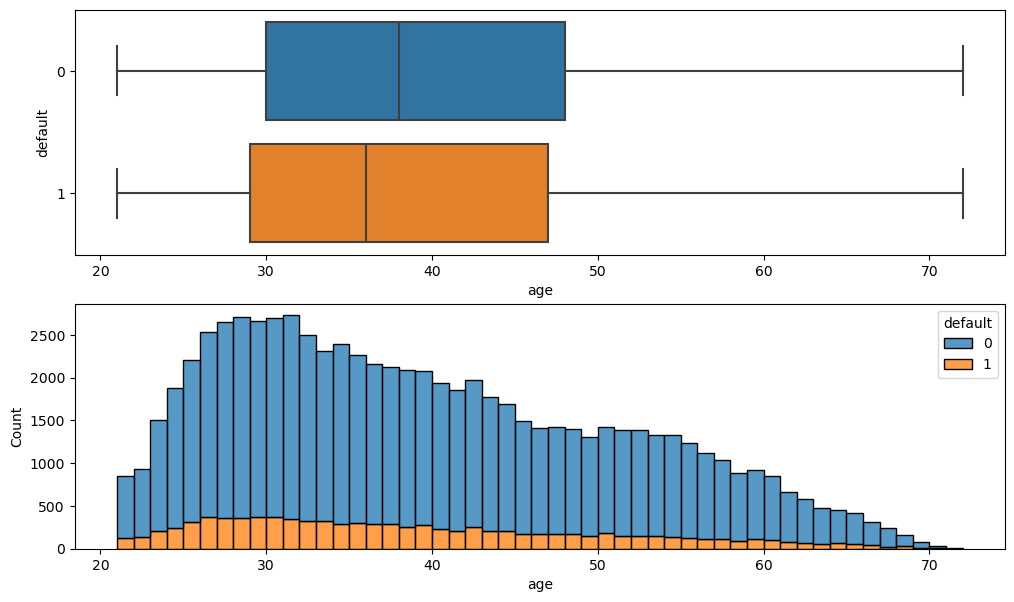

In [8]:
def get_axes(figsize=None):
    fig = plt.figure(figsize=figsize or (10, 5))
    
    return fig.add_axes([0, 0, 1, 1])

def build_histplot(x, hue=None, ax=None, palette=None, bins='auto'):
    return seaborn.histplot(
        x=x,
        hue=hue,
        bins=bins,
        palette=palette,
        multiple='stack',
        ax=ax or get_axes(),
    )

def build_boxplot(x, y, ax=None):
    return seaborn.boxplot(x=x, y=y, orient='h', ax=ax or get_axes())

def build_distplots(x, y, shape=(2, 1), figsize=None, palette=None):
    fig = plt.figure(figsize=figsize or (6 * shape[0], 7 * shape[1]))
    axes = fig.subplots(*shape)

    boxplot = build_boxplot(x, y, ax=axes[0])
    histplot = build_histplot(x, y, ax=axes[1], palette=palette)

    return axes

build_distplots(
    train_df['age'],
    train_df['default']
);

    age   default
0    21  0.144876
1    22  0.147279
2    23  0.134526
3    24  0.132408
4    25  0.143052
5    26  0.148734
6    27  0.137240
7    28  0.133826
8    29  0.138774
9    30  0.137765
10   31  0.127246
11   32  0.128749
12   33  0.140017
13   34  0.121503
14   35  0.131031
15   36  0.133395
16   37  0.135033
17   38  0.123563
18   39  0.133045
19   40  0.118012
20   41  0.111470
21   42  0.130258
22   43  0.116949
23   44  0.122485
24   45  0.112307
25   46  0.124378
26   47  0.122708
27   48  0.120370
28   49  0.111963
29   50  0.126404
30   51  0.111191
31   52  0.111031
32   53  0.107843
33   54  0.099548
34   55  0.105691
35   56  0.103232
36   57  0.114423
37   58  0.106697
38   59  0.126486
39   60  0.122209
40   61  0.124054
41   62  0.123264
42   63  0.104822
43   64  0.142539
44   65  0.135071
45   66  0.145631
46   67  0.100806
47   68  0.163636
48   69  0.086420
49   70  0.218750
50   71  0.000000
51   72  0.500000


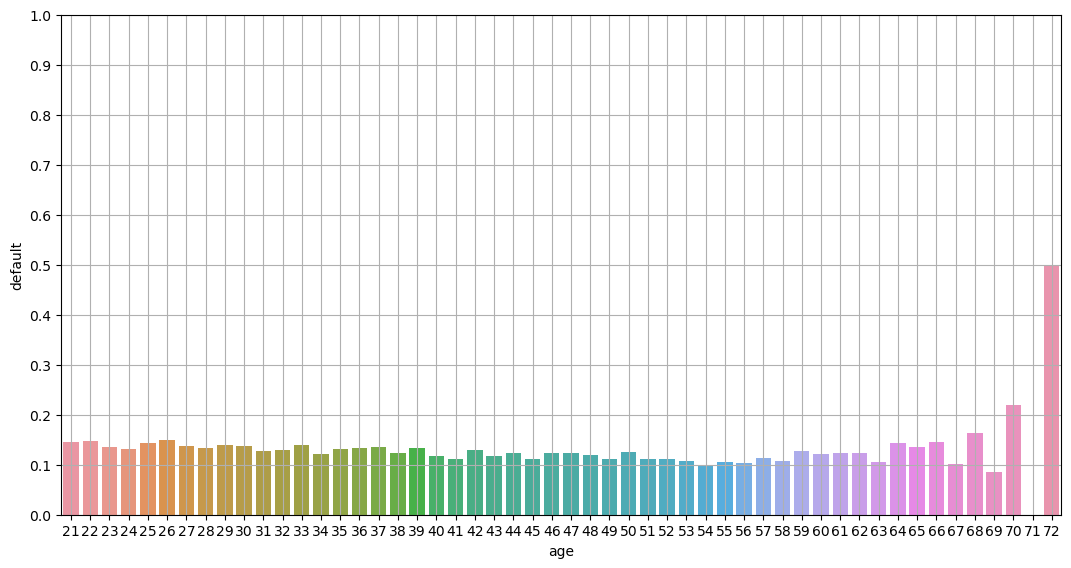

In [9]:
def build_barplot(x, y, scale=(0, 1), step=0.1, figsize=None):
    plot = seaborn.barplot(y=y, x=x, ax=get_axes(figsize))
    plot.set_yticks(np.arange(scale[0], scale[1] + step, step))
    plot.grid()

    return plot

default_by_age = train_df.groupby('age', as_index=False)['default'].mean()
print(default_by_age)
    
build_barplot(default_by_age['age'], default_by_age['default']);

Из построенных графиков можем видеть, что медианный возраст дефолтных клиентов ниже. Явных выбросов по распределению не наблюдается. В процентном соотношении количество дефолтных клиентов в каждой возрастной группе варьируется в районе 11-14%. В старшей возрастной группе есть подозрительные значения (8-16-50%, возможно вызванные невысоким количеством наблюдений в этих группах). Взглянем на них поближе.

In [10]:
for i in [68, 69, 70, 71, 72]:
    display(train_df[train_df['age'] == i])

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
392,90329,07APR2014,GRD,M,68,N,N,0,0,-2.024100,2,80,2,3,35000,1,4,N,0
716,68978,17MAR2014,GRD,F,68,N,N,0,1,-1.965093,1,50,1,2,34000,1,1,N,0
745,2629,08JAN2014,GRD,M,68,N,N,0,0,-1.728511,0,80,2,3,60000,4,1,N,0
1853,100175,17APR2014,UGR,F,68,N,N,0,0,-2.197753,1,50,2,3,22000,1,4,N,0
2018,84323,01APR2014,SCH,F,68,N,N,0,0,-2.229665,0,20,2,3,21000,1,3,N,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71074,98865,15APR2014,SCH,M,68,Y,N,0,0,-2.104211,1,80,2,3,10500,1,4,N,0
71260,59190,07MAR2014,SCH,F,68,N,N,1,0,-1.681253,1,40,2,3,15000,2,3,N,0
72472,109185,29APR2014,ACD,M,68,Y,Y,0,1,-2.061362,2,80,2,3,150000,1,4,Y,0
72484,91752,08APR2014,GRD,F,68,N,N,0,0,-1.856742,0,80,2,3,15000,3,1,N,0


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
1460,81075,29MAR2014,SCH,M,69,N,N,0,0,-2.225004,3,40,2,3,12000,2,3,N,0
1918,73381,21MAR2014,SCH,M,69,N,N,0,1,-1.999182,3,70,1,1,24100,1,3,N,0
3530,91908,08APR2014,SCH,F,69,N,N,0,0,-1.775263,1,50,2,3,11600,4,1,N,0
5365,28825,04FEB2014,GRD,F,69,N,N,0,0,-1.812376,0,80,2,3,23500,4,1,N,1
7148,95397,11APR2014,SCH,F,69,N,N,0,0,-2.089274,2,50,2,3,15000,1,3,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70729,48690,25FEB2014,SCH,M,69,N,N,0,0,-2.033809,0,40,1,2,10650,1,2,N,0
71803,89187,05APR2014,SCH,F,69,N,N,0,0,-2.588815,3,50,1,1,17000,1,2,N,0
71901,51757,28FEB2014,SCH,F,69,N,N,0,0,-1.908686,0,50,2,3,17000,4,1,N,0
72236,29403,05FEB2014,SCH,F,69,N,N,0,0,-2.169664,0,40,2,3,13000,1,3,N,0


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
1581,102778,21APR2014,SCH,F,70,N,N,0,0,-1.519631,1,50,2,3,9000,4,1,N,0
2900,23442,30JAN2014,GRD,M,70,N,N,0,0,-1.147416,3,60,2,3,11000,4,1,N,0
4144,86720,03APR2014,SCH,F,70,N,N,0,0,-2.159906,1,50,2,3,11000,1,3,N,1
4314,43504,20FEB2014,GRD,F,70,N,N,0,0,-2.221302,0,50,2,3,12500,1,4,N,0
6616,18240,25JAN2014,SCH,F,70,N,N,0,0,-2.413033,1,50,2,3,15000,4,3,N,1
11991,42603,19FEB2014,GRD,F,70,N,N,1,0,-1.586282,3,60,1,2,9000,1,4,N,0
12286,20561,28JAN2014,SCH,F,70,N,N,0,0,-1.345480,2,60,2,3,10000,1,3,N,0
15340,24256,31JAN2014,SCH,F,70,N,N,1,0,-0.907660,5,80,1,2,14500,1,4,N,1
16132,73004,20MAR2014,SCH,F,70,Y,N,0,0,-2.134640,0,40,2,3,12000,4,1,N,1
18758,90641,07APR2014,SCH,F,70,N,N,0,0,-2.286857,0,50,2,3,11300,4,1,N,0


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
41337,39795,16FEB2014,SCH,F,71,N,N,0,0,-1.901780,1,60,1,1,12100,1,3,N,0
45598,52288,01MAR2014,SCH,M,71,Y,N,0,0,-2.570514,0,50,2,3,20000,1,3,N,0
69880,93548,09APR2014,GRD,M,71,Y,Y,0,0,-1.945085,0,80,2,3,18000,1,4,Y,0


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
8063,44514,20FEB2014,PGR,F,72,N,N,0,1,-2.001313,0,50,3,3,17000,4,1,N,1
17276,69490,18MAR2014,NaN,F,72,Y,N,0,0,-2.362503,0,80,2,3,35000,1,1,Y,0


Из выведенных графиков и таблиц можем увидеть, что наблюдений для клиентов в возрасте больше 70 очень мало, и поэтому количество дефолтных клиентов в них сильно отклоняется от количества клиентов в более младших возрастных группах. Это может исказить результат моделирования, поэтому удалим эти наблюдения из тренировочной выборки.

Проведём тест на нормальность распределения.

In [11]:
def check_normal_distribution(values, alpha=0.05):
    H0 = 'Данные распределены нормально'
    Ha = 'Данные распределены не нормально'

    p_value = shapiro(values)[0]
    is_normal_distribution = p_value > alpha
    
    if is_normal_distribution:
        print(f'p-value: {p_value} > {alpha}. {H0}')
    else:
        print(f'p-value: {p_value} < {alpha}. {Ha}')
        
    return is_normal_distribution

check_normal_distribution(train_df['age']);

p-value: 0.9561795667281835 > 0.05. Данные распределены нормально


/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 73799.
  res = hypotest_fun_out(*samples, **kwds)


В соответствии с проведённым тестом, распределение данных близко к нормальному. Произведём поиск выбросов методом z-отклонений.

In [12]:
def outliers_z_score(values):
    mean = np.mean(values)
    std = np.std(values)
    delta = 3 * std
    lower_bound = mean - delta
    upper_bound = mean + delta

    return values[(values < lower_bound) | (values > upper_bound)]

train_df = train_df.drop(outliers_z_score(train_df['age']).index)

Впоследствии применим к этому признаку `StandardScaler`.

In [13]:
std_cols.append('age')

### `education`

Уровень образования клиента. Категориальный признак.

По возрастанию уровня образования:

`SCH` - среднее образование

`UGR` - аналог бакалавра

`GRD` - магистр

`PGR` - магистр+стажировка

`ACD` - высшая категория образования

Единственный признак с пропусками в датасете.

Устраним пропуски, проверим его на наличие выбросов, визуализируем в разрезе дефолта/не-дефолта и произведём его кодировку.

Посмотрим общее соотношение уровня образования в датасете.

In [14]:
train_df['education'].value_counts(normalize=True) * 100

education
SCH    52.876504
GRD    31.792576
UGR    13.356556
PGR     1.710390
ACD     0.263974
Name: proportion, dtype: float64

Заполнять пропуски будем модой (`SCH`)

In [15]:
na_fill_values['education'] = train_df['education'].mode()[0]
train_df['education'] = train_df['education'].fillna(na_fill_values['education'])

/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/sit

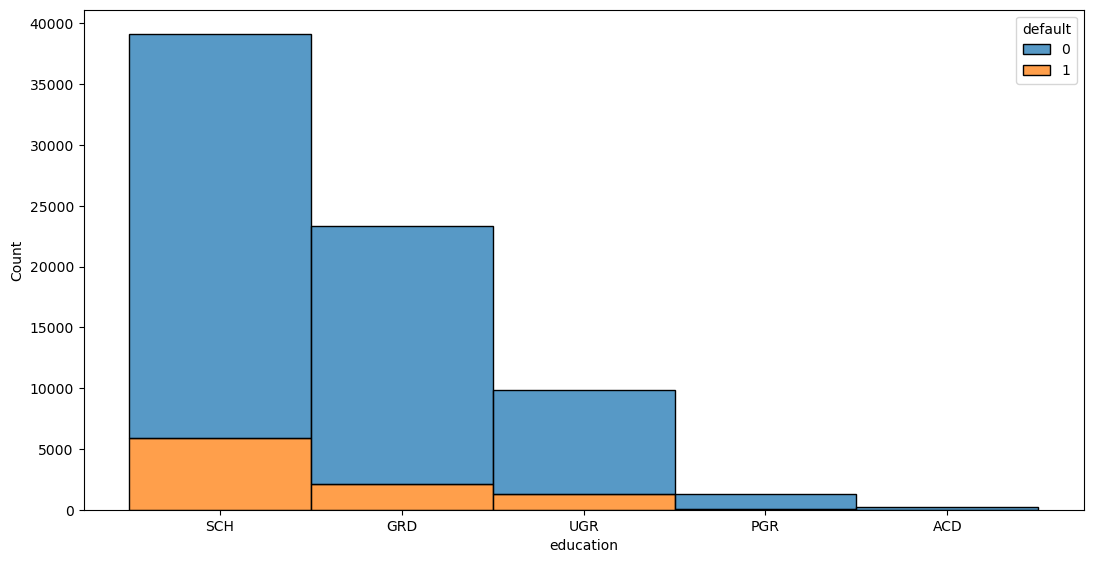

In [16]:
build_histplot(train_df['education'], train_df['default']);

,education,default
0,ACD,0.041237
1,GRD,0.090092
2,PGR,0.064439
3,SCH,0.150305
4,UGR,0.131520


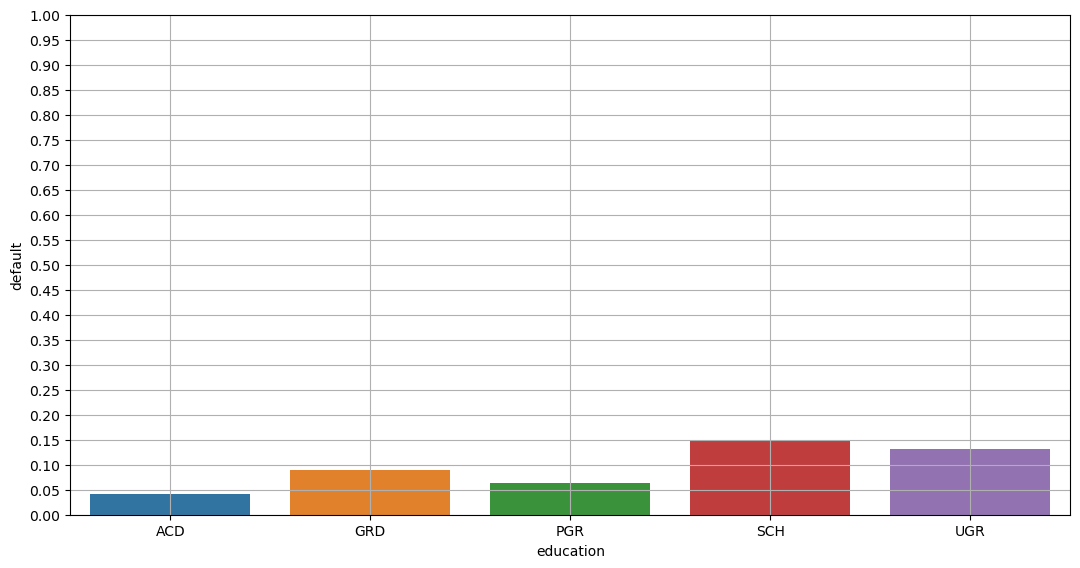

In [17]:
default_by_education = train_df.groupby('education', as_index=False)['default'].mean()

display(default_by_education)       # доля дефолтников среди людей с данным уровнем образования
build_barplot(default_by_education['education'], default_by_education['default'], step=0.05);

Из графиков можем видеть, что большая часть клиентов имеет среднее образование (`SCH`) и очень малая часть имеет образование уровня `ACD` и `PGR` (0.26% и 1.7% соответственно), что не является чем-то необычным. Также у этих уровней образования наблюдается самый низкий процент дефолтов (в 2-3 раза ниже, чем у `SCH` и `UGR`). Несмотря на малое количество наблюдений для этих уровней образования, считать их выбросами не будем, т.к. это может являться весомым фактором для определения платёжеспособности клиента.

*К этому признаку будем применять `OneHotEncoder`.*

*Потенциальный вариант улучшения моделирования: заполнять пропуски не модой, а на основе предсказний с помощью машинного обучения.*

In [18]:
one_hot_cols.append('education')

### `sex`

Пол клиента. Бинарный признак.

Визуализируем в разрезе дефолт/не-дефолт.

sex
F    0.563178
M    0.436822
Name: proportion, dtype: float64

/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/sit

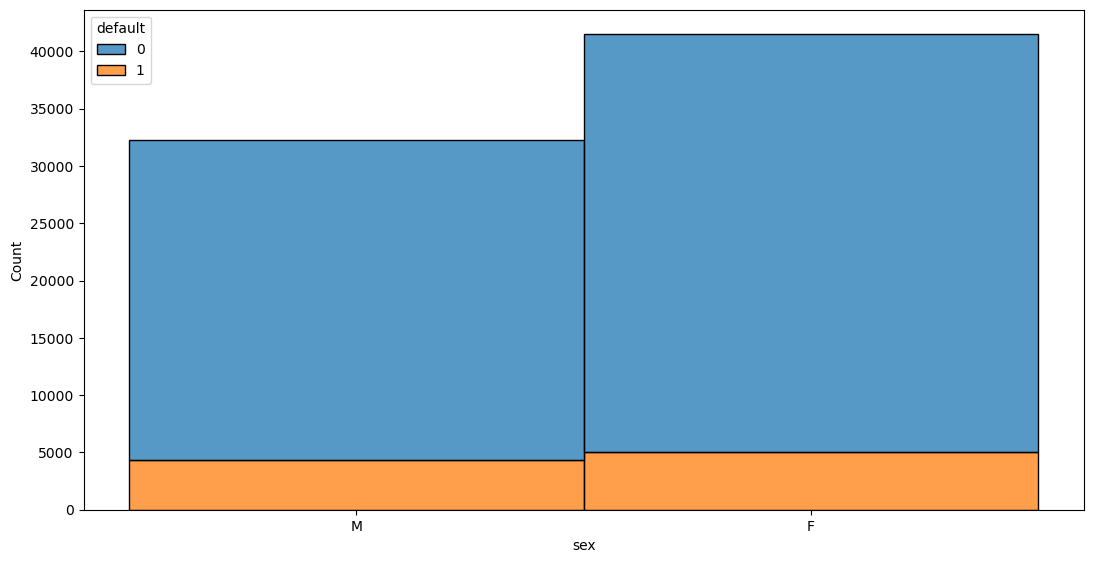

In [19]:
display(train_df['sex'].value_counts(normalize=True))
build_histplot(train_df['sex'], train_df['default']);

,sex,default
0,F,0.121241
1,M,0.134411


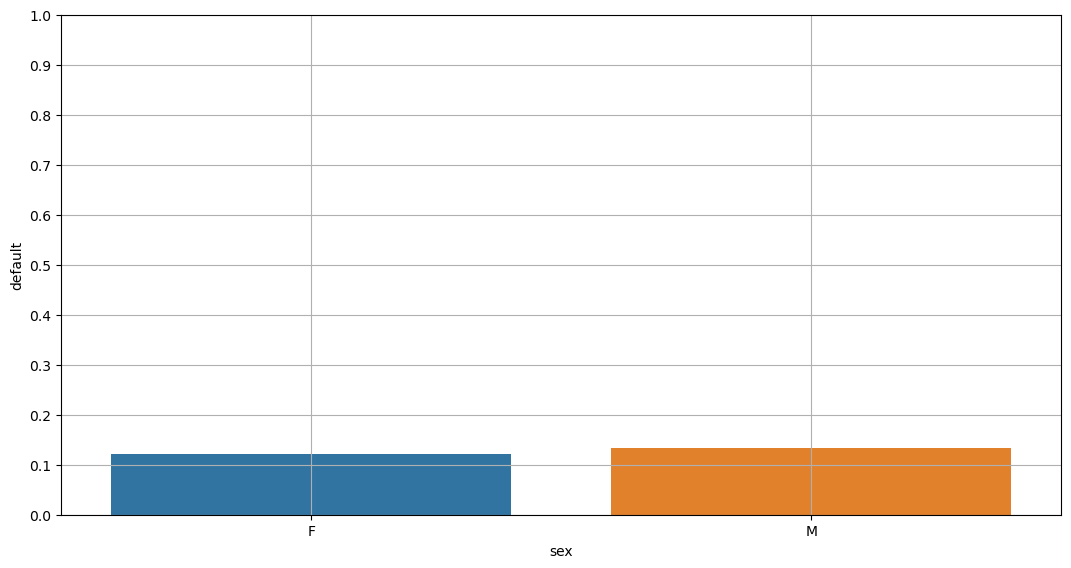

In [20]:
default_by_sex = train_df.groupby('sex', as_index=False)['default'].mean()

display(default_by_sex)
build_barplot(default_by_sex['sex'], default_by_sex['default']);

Соотношение женщин к мужчинам в датасете 43 к 56. Для каждого пола процент дефолтных клиентов 12-13%. Ничего необычного в содержимом признака нет.

*Будем перекодировать его в цифровой формат.*

In [21]:
bin_cols.append('sex')

### `car`

Флаг наличия автомобиля у клиента. Бинарный признак. 

Визуализируем признак в разрезе дефолт/не-дефолт.

car
N    0.67524
Y    0.32476
Name: proportion, dtype: float64

/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/sit

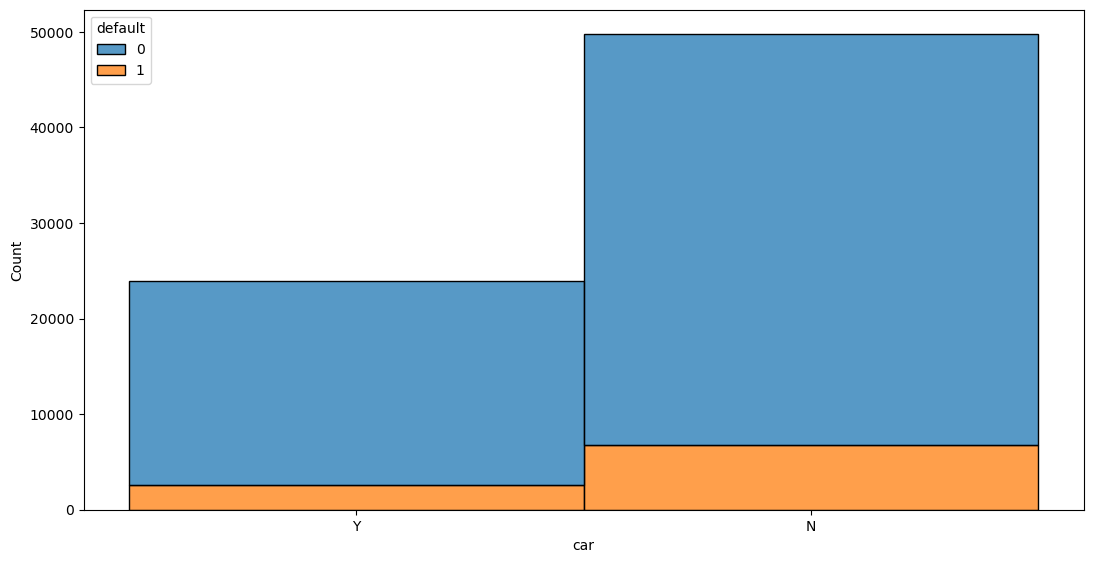

In [22]:
display(train_df['car'].value_counts(normalize=True))
build_histplot(train_df['car'], train_df['default']);

,car,default
0,N,0.136960
1,Y,0.106271


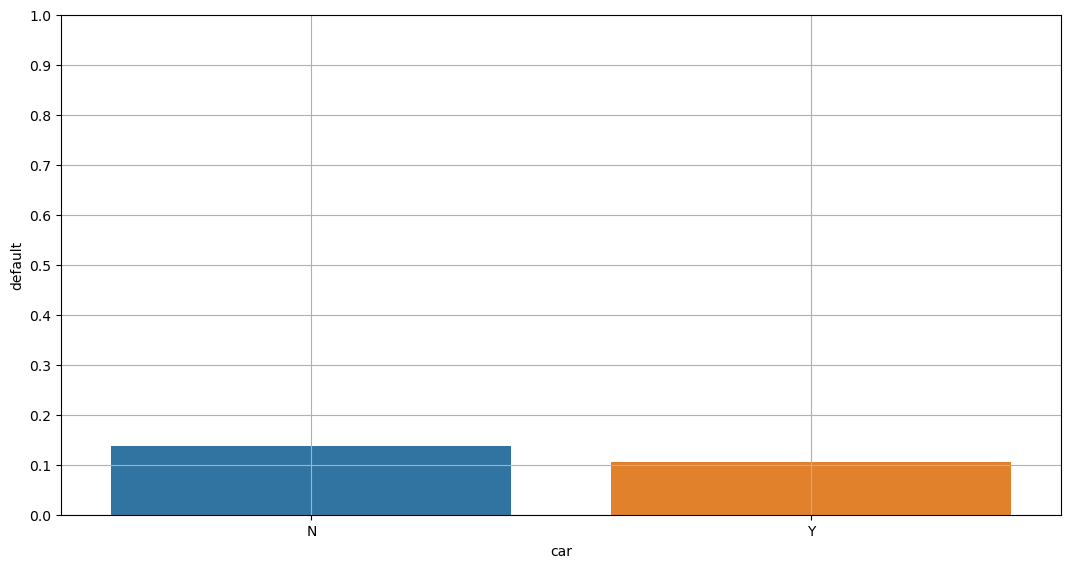

In [23]:
default_by_car = train_df.groupby('car', as_index=False)['default'].mean()

display(default_by_car)
build_barplot(default_by_car['car'], default_by_car['default']);

Соотношение клиентов с машиной к клиентам без машины 1 к 3. В разрезе дефолта/не-дефолта соотношение дефолтных к не-дефолтным клиентам на 3% больше среди клиентов без машины.

### `car_type`

Флаг наличия автомобиля-иномарки. Бинарный признак.

Вероятно, имеет тесную связь с признаком `car`.

Визуализируем признак в разрезе дефолт/не-дефолт, проверим связь с `car_type`, проверим на наличие выбросов.

car_type
N    0.810187
Y    0.189813
Name: proportion, dtype: float64

/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/sit

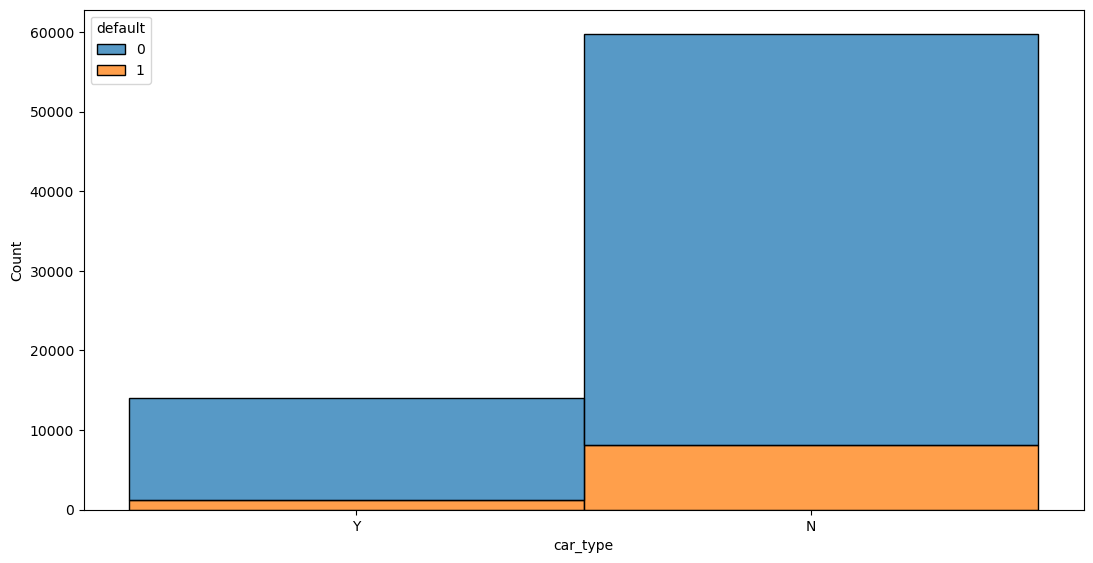

In [24]:
display(train_df['car_type'].value_counts(normalize=True))
build_histplot(train_df['car_type'], train_df['default']);

,car_type,default
0,N,0.136258
1,Y,0.087450


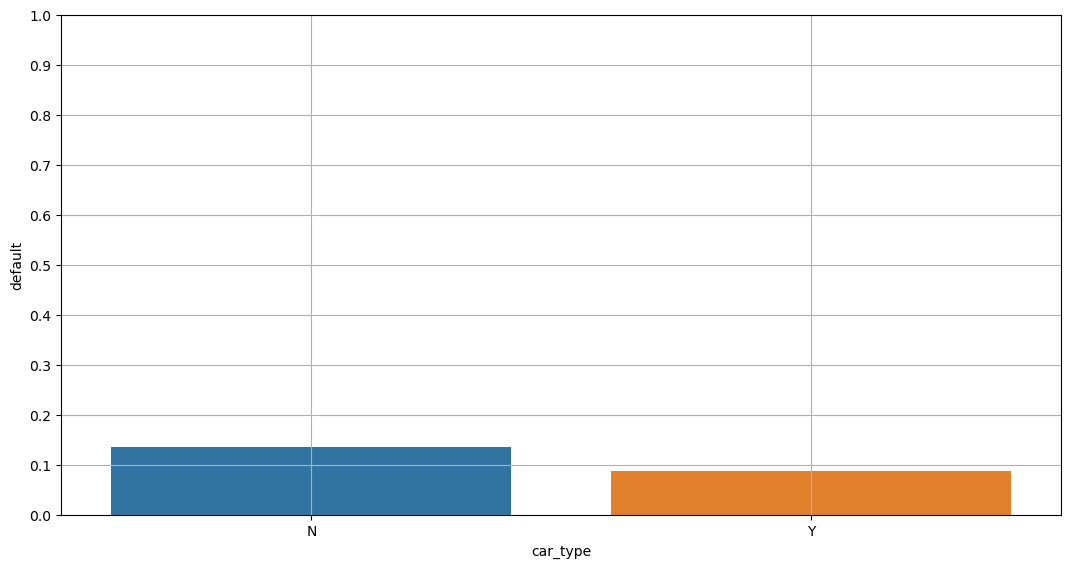

In [25]:
default_by_car_type = train_df.groupby('car_type', as_index=False)['default'].mean()

display(default_by_car_type)
build_barplot(default_by_car_type['car_type'], default_by_car_type['default']);

Также посмотрим на этот признак в разрезе клиентов с машинами.

In [26]:
clients_with_cars = train_df[train_df['car'] == 'Y']
clients_with_cars['car_type'].value_counts(normalize=True)

car_type
Y    0.58447
N    0.41553
Name: proportion, dtype: float64

,car_type,default
0,N,0.132744
1,Y,0.087450


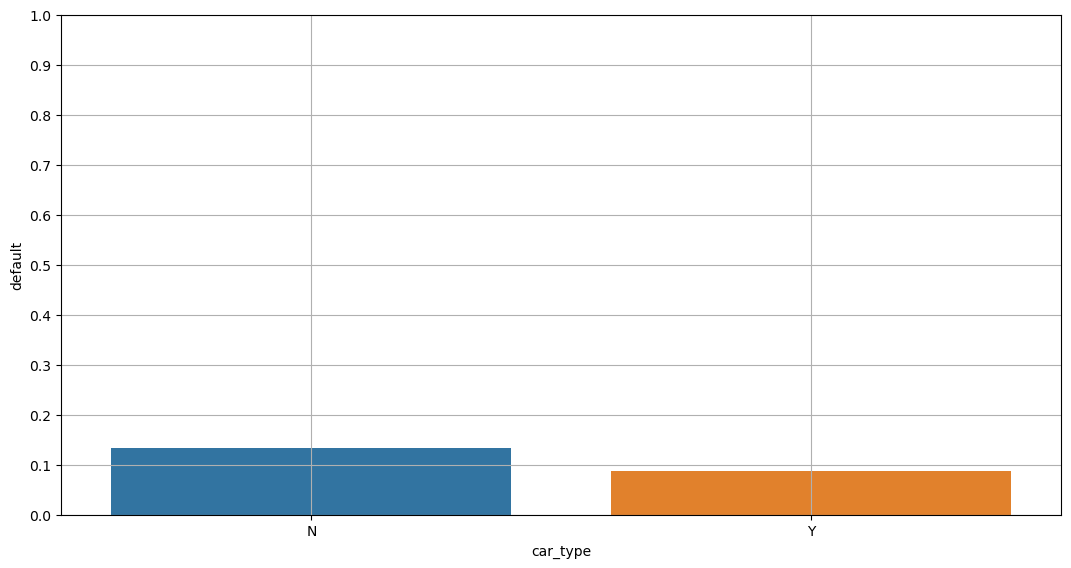

In [27]:
default_by_clients_with_cars_car_type = clients_with_cars.groupby('car_type', as_index=False)['default'].mean()

display(default_by_clients_with_cars_car_type)
build_barplot(
    default_by_clients_with_cars_car_type['car_type'],
    default_by_clients_with_cars_car_type['default'],
);

Соотношение клиентов без иномарок к клиентам с иномарками 4 к 1. В разрезе клиентов с машинами соотношение клиентов с иномарками и клиентам без иномарок 3 к 2 соответственно. В разрезе дефолта/не-дефолта соотношение дефолтных клиентов к не-дефолтным на 5% больше среди клиентов без иномарок вне зависимости от наличия автомобиля.

`car_type` целиком завязан на признак `car` и не может быть положительным без положительного `car`. На этом основании проверим данные признаки на выбросы.

In [28]:
train_df[(train_df['car'] == 'N') & (train_df['car_type'] == 'Y')].shape[0]

0

Выбросов среди признаков `car` и `car_type` нет.

*Для удобства в будущем переделаем признаки `car` и `car_type` в признаки `has_domestic_car` и `has_foreign_car`. Потенциально у клиентов могут быть 2 и больше машин - иномарки и отечественные, но, к сожалению, из предоставленных данных нет возможности узнать это, поэтому просто поделим клиентов на клиентов без машины, с отечественным авто и с иномаркой.*

In [29]:
cols_to_delete.extend(['car', 'car_type'])

### `decline_app_cnt`

Количество отклонённых заявок в прошлом. Числовой признак.

Визуализируем в разрезе дефолт/не-дефолт, проверим на выбросы.

/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/sit

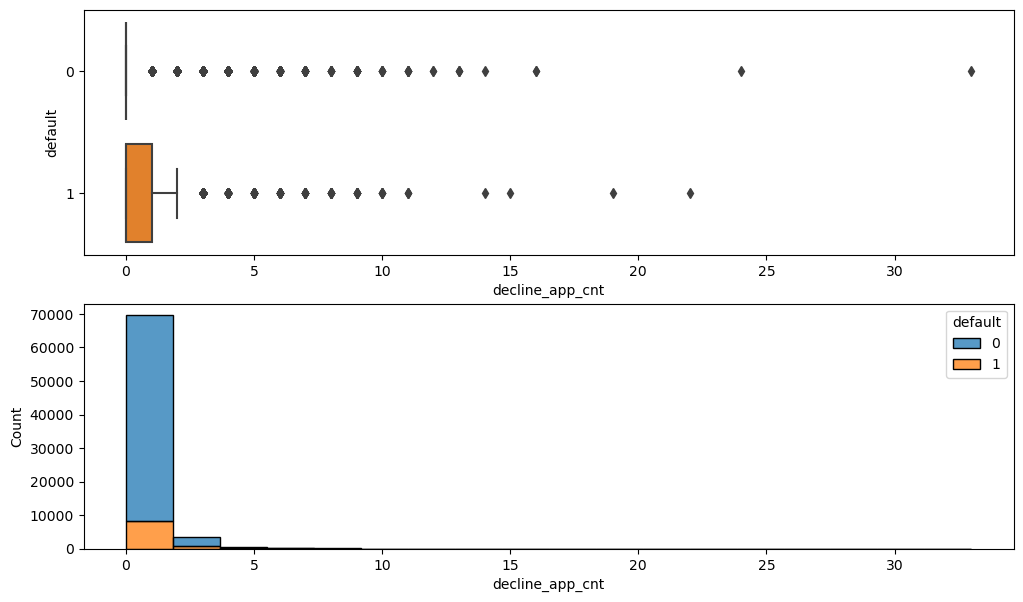

In [30]:
build_distplots(train_df['decline_app_cnt'], train_df['default']);

Большинство наблюдений нулевые или находятся около нуля. Наблюдается некоторое количество наблюдений с большими отклонениями для обоих типов клиентов. Среди дефолтных клиентов 75-й квартиль распределения больше, чем у не-дефолтных, т.е. дефолтным клиентам чаще отказывают.

Ознакомимся с наблюдениями с сильными отклонениями для данного показателя (начнём с 20 и будем понижать порог) и сравним их с данными из всего датасета, а также оценим корреляцию данного признака с целевым.

In [31]:
display(train_df.describe(), train_df[['decline_app_cnt', 'default']].corr())

for i in np.arange(20, 4, -5):
    filtered_data = train_df[train_df['decline_app_cnt'] > i]

    display(f'decline_app_cnt > {i}', filtered_data, filtered_data.describe(), filtered_data[['decline_app_cnt', 'default']].corr())

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,55137.965094,39.280641,0.275749,0.164894,-1.904724,2.000339,56.725701,1.575509,2.496280,41099.775417,1.733330,2.765458,0.126994
std,31841.921168,11.520378,0.804272,0.371087,0.498231,2.252073,13.055717,0.527631,0.689818,46166.322400,1.123622,1.009463,0.332968
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000
25%,27440.500000,30.000000,0.000000,0.000000,-2.259534,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000
50%,55274.000000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000
75%,82758.500000,48.000000,0.000000,0.000000,-1.569831,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000
max,110147.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000


,decline_app_cnt,default
decline_app_cnt,1.000000,0.113682
default,0.113682,1.000000


'decline_app_cnt > 20'

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
11117,37005,13FEB2014,GRD,F,22,Y,Y,22,0,-1.720038,3,60,2,3,40000,4,1,N,1
24547,108743,29APR2014,UGR,M,42,N,N,33,0,-0.988195,2,50,2,3,20000,4,1,N,0
57635,87562,03APR2014,GRD,F,48,Y,Y,24,0,-0.616087,3,40,2,3,320000,1,3,N,0


,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,3.000000,3.000000,3.000000,3.0,3.000000,3.000000,3.0,3.0,3.0,3.000000,3.000000,3.000000,3.000000
mean,77770.000000,37.333333,26.333333,0.0,-1.108107,2.666667,50.0,2.0,3.0,126666.666667,3.000000,1.666667,0.333333
std,36857.802553,13.613719,5.859465,0.0,0.561659,0.577350,10.0,0.0,0.0,167729.941672,1.732051,1.154701,0.577350
min,37005.000000,22.000000,22.000000,0.0,-1.720038,2.000000,40.0,2.0,3.0,20000.000000,1.000000,1.000000,0.000000
25%,62283.500000,32.000000,23.000000,0.0,-1.354116,2.500000,45.0,2.0,3.0,30000.000000,2.500000,1.000000,0.000000
50%,87562.000000,42.000000,24.000000,0.0,-0.988195,3.000000,50.0,2.0,3.0,40000.000000,4.000000,1.000000,0.000000
75%,98152.500000,45.000000,28.500000,0.0,-0.802141,3.000000,55.0,2.0,3.0,180000.000000,4.000000,2.000000,0.500000
max,108743.000000,48.000000,33.000000,0.0,-0.616087,3.000000,60.0,2.0,3.0,320000.000000,4.000000,3.000000,1.000000


,decline_app_cnt,default
decline_app_cnt,1.000000,-0.640464
default,-0.640464,1.000000


'decline_app_cnt > 15'

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
8579,87451,03APR2014,GRD,F,26,N,N,19,1,-1.265992,1,50,2,3,31000,1,3,Y,1
11117,37005,13FEB2014,GRD,F,22,Y,Y,22,0,-1.720038,3,60,2,3,40000,4,1,N,1
24547,108743,29APR2014,UGR,M,42,N,N,33,0,-0.988195,2,50,2,3,20000,4,1,N,0
57635,87562,03APR2014,GRD,F,48,Y,Y,24,0,-0.616087,3,40,2,3,320000,1,3,N,0
71455,41236,17FEB2014,GRD,M,29,Y,Y,16,0,-1.938158,4,60,1,2,35000,1,3,Y,0
73432,5896,13JAN2014,GRD,F,36,N,N,16,0,-1.499862,6,50,2,3,80000,1,3,N,0


,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,61315.500000,33.833333,21.666667,0.166667,-1.338055,3.166667,51.666667,1.833333,2.833333,87666.666667,2.000000,2.333333,0.333333
std,39209.230009,9.968283,6.408328,0.408248,0.486014,1.722401,7.527727,0.408248,0.408248,115648.893928,1.549193,1.032796,0.516398
min,5896.000000,22.000000,16.000000,0.000000,-1.938158,1.000000,40.000000,1.000000,2.000000,20000.000000,1.000000,1.000000,0.000000
25%,38062.750000,26.750000,16.750000,0.000000,-1.664994,2.250000,50.000000,2.000000,3.000000,32000.000000,1.000000,1.500000,0.000000
50%,64343.500000,32.500000,20.500000,0.000000,-1.382927,3.000000,50.000000,2.000000,3.000000,37500.000000,1.000000,3.000000,0.000000
75%,87534.250000,40.500000,23.500000,0.000000,-1.057644,3.750000,57.500000,2.000000,3.000000,70000.000000,3.250000,3.000000,0.750000
max,108743.000000,48.000000,33.000000,1.000000,-0.616087,6.000000,60.000000,2.000000,3.000000,320000.000000,4.000000,3.000000,1.000000


,decline_app_cnt,default
decline_app_cnt,1.000000,-0.141019
default,-0.141019,1.000000


'decline_app_cnt > 10'

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
6725,84378,01APR2014,SCH,F,41,N,N,13,0,-0.796768,18,40,2,3,20000,4,2,N,0
7910,71667,19MAR2014,PGR,M,39,Y,Y,11,0,-0.381112,8,30,2,3,90000,4,3,N,0
8579,87451,03APR2014,GRD,F,26,N,N,19,1,-1.265992,1,50,2,3,31000,1,3,Y,1
11117,37005,13FEB2014,GRD,F,22,Y,Y,22,0,-1.720038,3,60,2,3,40000,4,1,N,1
15694,15940,23JAN2014,UGR,M,38,N,N,13,0,-0.842077,0,60,2,3,45000,4,3,N,0
24547,108743,29APR2014,UGR,M,42,N,N,33,0,-0.988195,2,50,2,3,20000,4,1,N,0
26430,99043,16APR2014,SCH,F,24,N,N,14,0,-1.542346,0,80,2,3,40000,1,4,N,1
28957,4482,10JAN2014,SCH,F,26,N,N,12,0,-1.459988,2,60,1,2,25000,3,1,N,0
29655,1617,06JAN2014,GRD,F,26,N,N,14,1,-1.732861,24,60,2,3,30000,2,2,N,0
29910,29186,05FEB2014,SCH,M,21,N,N,13,0,-1.993726,0,40,2,3,60000,2,1,N,0


,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,54111.130435,32.434783,14.565217,0.086957,-1.308823,5.173913,53.043478,1.826087,2.826087,52869.565217,2.260870,2.260870,0.304348
std,36303.579794,10.924643,5.408966,0.288104,0.513426,6.198623,12.945614,0.491026,0.387553,61350.931198,1.286906,1.009833,0.470472
min,1617.000000,21.000000,11.000000,0.000000,-2.165837,0.000000,30.000000,1.000000,2.000000,18000.000000,1.000000,1.000000,0.000000
25%,21003.500000,22.500000,11.000000,0.000000,-1.709769,1.500000,40.000000,2.000000,3.000000,26500.000000,1.000000,1.000000,0.000000
50%,65141.000000,29.000000,13.000000,0.000000,-1.416570,2.000000,50.000000,2.000000,3.000000,40000.000000,2.000000,2.000000,0.000000
75%,86554.500000,40.000000,15.500000,0.000000,-0.894930,7.500000,60.000000,2.000000,3.000000,50000.000000,3.500000,3.000000,1.000000
max,108743.000000,55.000000,33.000000,1.000000,-0.381112,24.000000,80.000000,3.000000,3.000000,320000.000000,4.000000,4.000000,1.000000


,decline_app_cnt,default
decline_app_cnt,1.000000,0.018639
default,0.018639,1.000000


'decline_app_cnt > 5'

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
140,78525,26MAR2014,UGR,M,22,Y,N,6,0,-1.376744,1,80,2,3,30000,1,3,N,0
380,74896,22MAR2014,GRD,M,29,N,N,7,0,-1.705911,4,50,2,3,25000,1,3,N,1
1234,3428,09JAN2014,SCH,F,32,N,N,7,0,-1.205260,8,50,2,3,70000,1,4,N,1
1666,48234,25FEB2014,SCH,F,24,N,N,7,0,-1.251555,4,40,1,1,20000,1,3,N,0
1725,42493,19FEB2014,UGR,F,46,N,N,7,0,-1.518868,0,60,1,3,45000,1,2,Y,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73241,56574,05MAR2014,GRD,F,33,Y,Y,6,1,-1.273559,1,60,1,2,35000,1,3,N,0
73432,5896,13JAN2014,GRD,F,36,N,N,16,0,-1.499862,6,50,2,3,80000,1,3,N,0
73467,82019,30MAR2014,SCH,F,23,N,N,6,0,-1.615405,5,50,2,3,28000,1,3,N,1
73616,95260,11APR2014,UGR,F,22,Y,N,7,0,-1.337067,3,50,2,3,25000,1,2,N,0


,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000
mean,50688.647059,32.105042,7.676471,0.113445,-1.406542,4.575630,54.453782,1.651261,2.558824,40272.689076,2.130252,2.441176,0.331933
std,31999.831239,10.040083,3.031542,0.317805,0.478251,5.918625,13.229393,0.519878,0.683366,33197.137317,1.271170,0.995086,0.471899
min,297.000000,21.000000,6.000000,0.000000,-3.006112,0.000000,20.000000,1.000000,1.000000,5000.000000,1.000000,1.000000,0.000000
25%,22242.000000,24.250000,6.000000,0.000000,-1.723174,1.000000,50.000000,1.000000,2.000000,24000.000000,1.000000,2.000000,0.000000
50%,50965.500000,29.000000,7.000000,0.000000,-1.425998,3.000000,50.000000,2.000000,3.000000,32000.000000,2.000000,3.000000,0.000000
75%,77394.000000,37.000000,8.000000,0.000000,-1.091241,6.000000,60.000000,2.000000,3.000000,45000.000000,4.000000,3.000000,1.000000
max,109683.000000,63.000000,33.000000,1.000000,0.199773,46.000000,80.000000,3.000000,3.000000,320000.000000,4.000000,4.000000,1.000000


,decline_app_cnt,default
decline_app_cnt,1.000000,0.028193
default,0.028193,1.000000


Из построенных таблиц видим, что клиентов с большим количеством отклонённых заявок (больше 5) - несколько сотен, при этом корреляция данного признака с целевым из подвыборок ниже, чем в основном датасете и находится около нуля, т.е. прямой взаимосвязи между признаками нет.

Проведём тест на нормальность распределения.

In [32]:
check_normal_distribution(train_df['decline_app_cnt'])

p-value: 0.38056410833183785 > 0.05. Данные распределены нормально


/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 73799.
  res = hypotest_fun_out(*samples, **kwds)


np.True_

Результат теста неоднозначный - распределение данных близко к нормальному, однако на графиках мы этого не наблюдаем.

Пока будем считать, что данные распределены ненормально, поэтому поиск выбросов через z-отклоенение отбрасываем. Т.к. 25 и 75 квартиль равны нулю, мы также не можем воспользоваться методом Тьюки. Поэтому установим порог в 5 отказов и уберём наблюдения, где значение превышает этот порог.

In [33]:
train_df = train_df.drop(train_df[train_df['decline_app_cnt'] > 5].index)

*В дальнейшем применим к нему `RobustScaler`, т.к. распределение ненормальное.*

*Потенциальный вариант улучшения модели: переделать признак в категориальный (0, 1-2, 3-4, 5+), либо установить вместо всех высоких значений значение 5. Также можно логарифмировать признак и удалять выбросы с методом z-отклонений.*

In [34]:
robust_cols.append('decline_app_cnt')

### `good_work`

Флаг наличия "хорошей" работы (что бы это ни значило). Бинарный признак.

Визуализируем его в разрезе дефолт/не-дефолт.

good_work
0    83.493971
1    16.506029
Name: proportion, dtype: float64

/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/sit

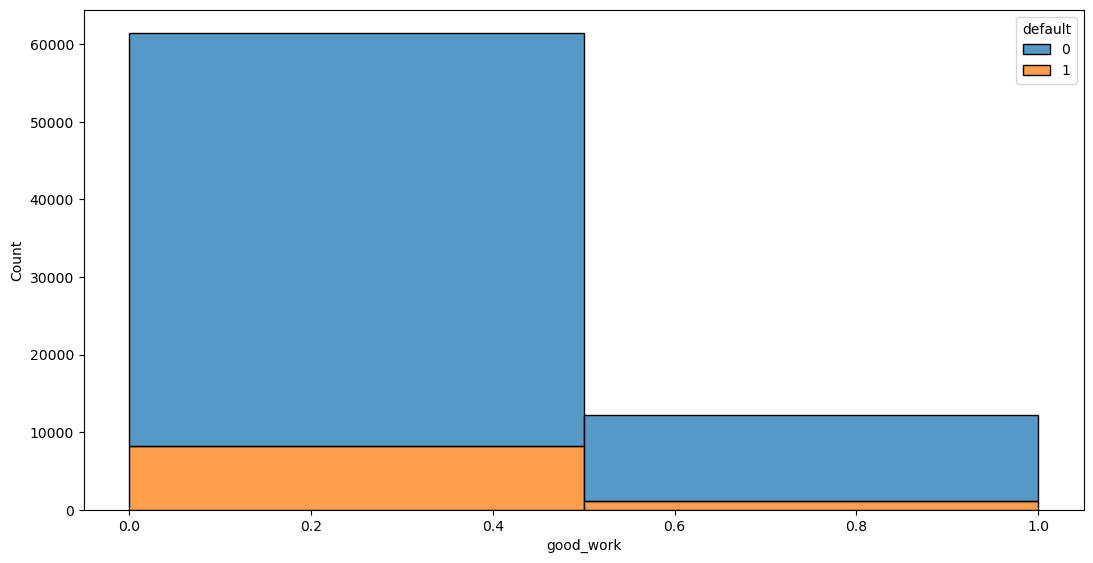

In [35]:
display(train_df['good_work'].value_counts(normalize=True) * 100)
build_histplot(train_df['good_work'], train_df['default'], bins=train_df['good_work'].nunique());

,good_work,default
0,0,0.132695
1,1,0.094136


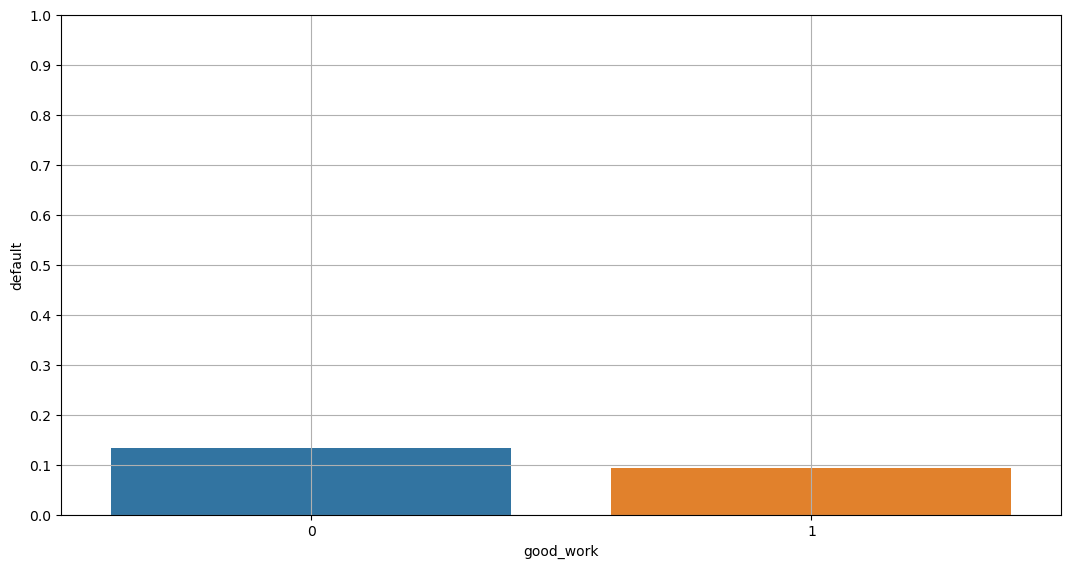

In [36]:
default_by_good_work = train_df.groupby('good_work', as_index=False)['default'].mean()

display(default_by_good_work)
build_barplot(default_by_good_work['good_work'], default_by_good_work['default']);

"Хорошая" работа есть только у 16% клиентов, представленных в датасете. Среди клиентов с "хорошей" работой дефолтов меньше на 3%.

*Признак в кодировке не нуждается.*

In [37]:
bin_cols.append('good_work')

### `bki_request_cnt`

Количество запросов в БКИ. Числовой признак.

Визуализируем в разрезе дефолт/не-дефолт, проверим на наличие выбросов. Также проверим связь с `decline_app_cnt`.

bki_request_cnt
0     26.288387
1     24.788951
2     18.644390
3     12.460407
4      7.626324
5      4.419461
6      2.301491
7      1.145988
8      0.675630
9      0.403747
10     0.297712
11     0.251492
12     0.190318
13     0.126426
14     0.114191
15     0.070690
16     0.044861
18     0.028548
17     0.024469
19     0.020391
21     0.016313
24     0.010875
20     0.010875
23     0.009516
22     0.005438
28     0.005438
32     0.002719
27     0.002719
25     0.002719
34     0.001359
26     0.001359
36     0.001359
53     0.001359
45     0.001359
33     0.001359
41     0.001359
Name: proportion, dtype: float64

/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/sit

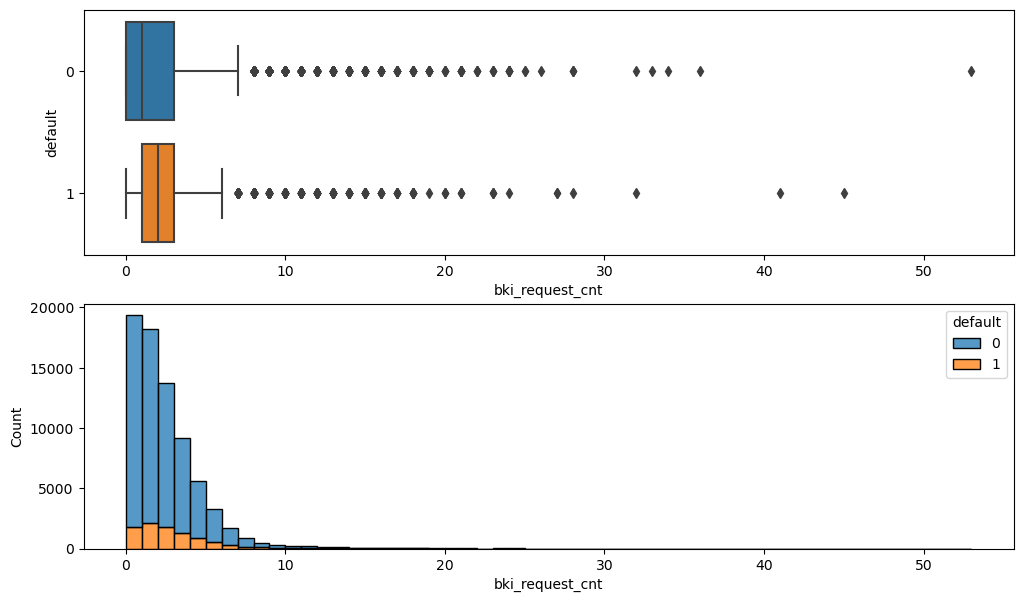

In [38]:
display(train_df['bki_request_cnt'].value_counts(normalize=True) * 100)
build_distplots(train_df['bki_request_cnt'], train_df['default']);

На графиках видим, что в признаке есть достаточно большие значения для обоих категорий клиентов, которые, вероятно, могут являться выбросами. Ознакомимся с ними. Начнём с установления порога в 50 заявок и будем снижать до 5 с шагом в 5.

In [39]:
display(train_df.describe(), train_df[['bki_request_cnt', 'default']].corr())

for i in np.arange(50, 4, -5):
    filtered_data = train_df[train_df['bki_request_cnt'] > i]

    print(f'bki_request_cnt > {i}'.center(50, '-'))

    display(filtered_data[['bki_request_cnt', 'default']].corr(), filtered_data.describe(), filtered_data)

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,73561.000000,73561.000000,73561.000000,73561.000000,73561.000000,73561.000000,73561.000000,73561.000000,73561.000000,73561.00000,73561.000000,73561.000000,73561.000000
mean,55152.360463,39.303857,0.251805,0.165060,-1.906335,1.992007,56.733051,1.575264,2.496078,41102.45138,1.732046,2.766507,0.126331
std,31840.618540,11.517665,0.664496,0.371237,0.497489,2.225725,13.054601,0.527642,0.689835,46202.51369,1.122895,1.009347,0.332224
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.00000,1.000000,1.000000,0.000000
25%,27453.000000,30.000000,0.000000,0.000000,-2.260560,0.000000,50.000000,1.000000,2.000000,20000.00000,1.000000,2.000000,0.000000
50%,55296.000000,37.000000,0.000000,0.000000,-1.921778,1.000000,50.000000,2.000000,3.000000,30000.00000,1.000000,3.000000,0.000000
75%,82783.000000,48.000000,0.000000,0.000000,-1.572336,3.000000,60.000000,2.000000,3.000000,48000.00000,2.000000,4.000000,0.000000
max,110147.000000,72.000000,5.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.00000,4.000000,4.000000,1.000000


,bki_request_cnt,default
bki_request_cnt,1.000000,0.075603
default,0.075603,1.000000


---------------bki_request_cnt > 50---------------


,bki_request_cnt,default
bki_request_cnt,NaN,NaN
default,NaN,NaN


,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,12395.0,38.0,0.0,0.0,-2.623103,53.0,60.0,1.0,1.0,65000.0,1.0,3.0,0.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,12395.0,38.0,0.0,0.0,-2.623103,53.0,60.0,1.0,1.0,65000.0,1.0,3.0,0.0
25%,12395.0,38.0,0.0,0.0,-2.623103,53.0,60.0,1.0,1.0,65000.0,1.0,3.0,0.0
50%,12395.0,38.0,0.0,0.0,-2.623103,53.0,60.0,1.0,1.0,65000.0,1.0,3.0,0.0
75%,12395.0,38.0,0.0,0.0,-2.623103,53.0,60.0,1.0,1.0,65000.0,1.0,3.0,0.0
max,12395.0,38.0,0.0,0.0,-2.623103,53.0,60.0,1.0,1.0,65000.0,1.0,3.0,0.0


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
27639,12395,20JAN2014,GRD,F,38,Y,Y,0,0,-2.623103,53,60,1,1,65000,1,3,Y,0


---------------bki_request_cnt > 45---------------


,bki_request_cnt,default
bki_request_cnt,NaN,NaN
default,NaN,NaN


,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,12395.0,38.0,0.0,0.0,-2.623103,53.0,60.0,1.0,1.0,65000.0,1.0,3.0,0.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,12395.0,38.0,0.0,0.0,-2.623103,53.0,60.0,1.0,1.0,65000.0,1.0,3.0,0.0
25%,12395.0,38.0,0.0,0.0,-2.623103,53.0,60.0,1.0,1.0,65000.0,1.0,3.0,0.0
50%,12395.0,38.0,0.0,0.0,-2.623103,53.0,60.0,1.0,1.0,65000.0,1.0,3.0,0.0
75%,12395.0,38.0,0.0,0.0,-2.623103,53.0,60.0,1.0,1.0,65000.0,1.0,3.0,0.0
max,12395.0,38.0,0.0,0.0,-2.623103,53.0,60.0,1.0,1.0,65000.0,1.0,3.0,0.0


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
27639,12395,20JAN2014,GRD,F,38,Y,Y,0,0,-2.623103,53,60,1,1,65000,1,3,Y,0


---------------bki_request_cnt > 40---------------


,bki_request_cnt,default
bki_request_cnt,1.000000,-0.944911
default,-0.944911,1.000000


,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,3.000000,3.000000,3.000000,3.0,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,15391.333333,39.333333,1.000000,0.0,-1.109431,46.333333,53.333333,1.666667,2.333333,41666.666667,3.000000,2.666667,0.666667
std,14623.569412,10.066446,1.732051,0.0,1.317239,6.110101,5.773503,0.577350,1.154701,20816.659995,1.732051,0.577350,0.577350
min,2498.000000,30.000000,0.000000,0.0,-2.623103,41.000000,50.000000,1.000000,1.000000,25000.000000,1.000000,2.000000,0.000000
25%,7446.500000,34.000000,0.000000,0.0,-1.552498,43.000000,50.000000,1.500000,2.000000,30000.000000,2.500000,2.500000,0.500000
50%,12395.000000,38.000000,0.000000,0.0,-0.481892,45.000000,50.000000,2.000000,3.000000,35000.000000,4.000000,3.000000,1.000000
75%,21838.000000,44.000000,1.500000,0.0,-0.352596,49.000000,55.000000,2.000000,3.000000,50000.000000,4.000000,3.000000,1.000000
max,31281.000000,50.000000,3.000000,0.0,-0.223299,53.000000,60.000000,2.000000,3.000000,65000.000000,4.000000,3.000000,1.000000


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
27639,12395,20JAN2014,GRD,F,38,Y,Y,0,0,-2.623103,53,60,1,1,65000,1,3,Y,0
33206,2498,08JAN2014,UGR,F,50,Y,Y,3,0,-0.481892,45,50,2,3,25000,4,3,N,1
55405,31281,07FEB2014,GRD,F,30,N,N,0,0,-0.223299,41,50,2,3,35000,4,2,N,1


---------------bki_request_cnt > 35---------------


,bki_request_cnt,default
bki_request_cnt,1.00000,-0.12058
default,-0.12058,1.00000


,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,4.000000,4.000000,4.000000,4.0,4.000000,4.000000,4.000000,4.00,4.0,4.00000,4.000000,4.00000,4.00000
mean,26384.750000,41.500000,1.750000,0.0,-1.187615,43.750000,60.000000,1.75,2.5,45822.50000,2.500000,2.50000,0.50000
std,25019.726116,9.291573,2.061553,0.0,1.086829,7.182154,14.142136,0.50,1.0,18920.16627,1.732051,0.57735,0.57735
min,2498.000000,30.000000,0.000000,0.0,-2.623103,36.000000,50.000000,1.00,1.0,25000.00000,1.000000,2.00000,0.00000
25%,9920.750000,36.000000,0.000000,0.0,-1.722399,39.750000,50.000000,1.75,2.5,32500.00000,1.000000,2.00000,0.00000
50%,21838.000000,43.000000,1.500000,0.0,-0.952029,43.000000,55.000000,2.00,3.0,46645.00000,2.500000,2.50000,0.50000
75%,38302.000000,48.500000,3.250000,0.0,-0.417244,47.000000,65.000000,2.00,3.0,59967.50000,4.000000,3.00000,1.00000
max,59365.000000,50.000000,4.000000,0.0,-0.223299,53.000000,80.000000,2.00,3.0,65000.00000,4.000000,3.00000,1.00000


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
25661,59365,07MAR2014,GRD,F,48,Y,N,4,0,-1.422165,36,80,2,3,58290,1,2,N,0
27639,12395,20JAN2014,GRD,F,38,Y,Y,0,0,-2.623103,53,60,1,1,65000,1,3,Y,0
33206,2498,08JAN2014,UGR,F,50,Y,Y,3,0,-0.481892,45,50,2,3,25000,4,3,N,1
55405,31281,07FEB2014,GRD,F,30,N,N,0,0,-0.223299,41,50,2,3,35000,4,2,N,1


---------------bki_request_cnt > 30---------------


,bki_request_cnt,default
bki_request_cnt,1.000000,0.118747
default,0.118747,1.000000


,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,8.00000,8.000000,8.00000,8.0,8.000000,8.000000,8.000000,8.00000,8.000000,8.000000,8.000000,8.00000,8.000000
mean,36344.25000,44.625000,1.62500,0.0,-1.202675,38.250000,62.500000,1.75000,2.625000,125411.250000,2.250000,2.37500,0.375000
std,25882.77161,9.515964,1.59799,0.0,0.813156,7.554563,12.817399,0.46291,0.744024,159753.770842,1.488048,1.06066,0.517549
min,2498.00000,30.000000,0.00000,0.0,-2.623103,32.000000,50.000000,1.00000,1.000000,25000.000000,1.000000,1.00000,0.000000
25%,13642.25000,37.000000,0.00000,0.0,-1.677995,32.750000,50.000000,1.75000,2.750000,33750.000000,1.000000,1.75000,0.000000
50%,34744.50000,47.500000,1.50000,0.0,-1.260005,35.000000,60.000000,2.00000,3.000000,49145.000000,1.500000,2.50000,0.000000
75%,59384.50000,51.000000,3.00000,0.0,-0.465291,42.000000,72.500000,2.00000,3.000000,123750.000000,4.000000,3.00000,1.000000
max,73506.00000,56.000000,4.00000,0.0,-0.223299,53.000000,80.000000,2.00000,3.000000,450000.000000,4.000000,4.00000,1.000000


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
655,73506,21MAR2014,UGR,M,34,Y,Y,2,0,-1.680424,34,50,1,2,40000,2,3,N,0
8944,59443,07MAR2014,GRD,M,54,Y,Y,1,0,-1.677185,32,80,2,3,450000,1,4,Y,0
19275,38208,14FEB2014,SCH,F,56,N,N,0,0,-0.415486,32,60,2,3,300000,4,1,N,1
25661,59365,07MAR2014,GRD,F,48,Y,N,4,0,-1.422165,36,80,2,3,58290,1,2,N,0
27639,12395,20JAN2014,GRD,F,38,Y,Y,0,0,-2.623103,53,60,1,1,65000,1,3,Y,0
33206,2498,08JAN2014,UGR,F,50,Y,Y,3,0,-0.481892,45,50,2,3,25000,4,3,N,1
39719,14058,21JAN2014,SCH,M,47,Y,N,3,0,-1.097846,33,70,2,3,30000,1,1,N,0
55405,31281,07FEB2014,GRD,F,30,N,N,0,0,-0.223299,41,50,2,3,35000,4,2,N,1


---------------bki_request_cnt > 25---------------


,bki_request_cnt,default
bki_request_cnt,1.000000,0.014544
default,0.014544,1.000000


,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,40973.866667,40.533333,1.666667,0.200000,-1.105847,33.200000,61.333333,1.600000,2.666667,103286.000000,1.666667,2.400000,0.400000
std,23501.206397,10.888176,1.543033,0.414039,0.638408,7.747811,11.872337,0.507093,0.617213,129739.507465,1.234427,1.121224,0.507093
min,161.000000,25.000000,0.000000,0.000000,-2.623103,26.000000,50.000000,1.000000,1.000000,25000.000000,1.000000,1.000000,0.000000
25%,22669.500000,32.000000,0.000000,0.000000,-1.522843,28.000000,50.000000,1.000000,2.500000,32500.000000,1.000000,1.500000,0.000000
50%,47964.000000,38.000000,1.000000,0.000000,-1.097846,32.000000,60.000000,2.000000,3.000000,55000.000000,1.000000,2.000000,0.000000
75%,58266.500000,49.000000,3.000000,0.000000,-0.590746,35.000000,70.000000,2.000000,3.000000,62500.000000,1.500000,3.000000,1.000000
max,73506.000000,56.000000,4.000000,1.000000,-0.223299,53.000000,80.000000,2.000000,3.000000,450000.000000,4.000000,4.000000,1.000000


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
655,73506,21MAR2014,UGR,M,34,Y,Y,2,0,-1.680424,34,50,1,2,40000,2,3,N,0
2493,161,02JAN2014,GRD,M,26,Y,Y,1,0,-0.592305,26,70,1,3,55000,1,1,N,0
8944,59443,07MAR2014,GRD,M,54,Y,Y,1,0,-1.677185,32,80,2,3,450000,1,4,Y,0
19275,38208,14FEB2014,SCH,F,56,N,N,0,0,-0.415486,32,60,2,3,300000,4,1,N,1
22093,46380,22FEB2014,SCH,F,38,Y,Y,4,1,-1.623521,27,50,2,3,30000,1,4,N,1
25661,59365,07MAR2014,GRD,F,48,Y,N,4,0,-1.422165,36,80,2,3,58290,1,2,N,0
27639,12395,20JAN2014,GRD,F,38,Y,Y,0,0,-2.623103,53,60,1,1,65000,1,3,Y,0
33206,2498,08JAN2014,UGR,F,50,Y,Y,3,0,-0.481892,45,50,2,3,25000,4,3,N,1
39719,14058,21JAN2014,SCH,M,47,Y,N,3,0,-1.097846,33,70,2,3,30000,1,1,N,0
42235,57168,05MAR2014,GRD,F,43,Y,N,0,1,-1.188249,28,80,2,3,280000,1,3,N,0


---------------bki_request_cnt > 20---------------


,bki_request_cnt,default
bki_request_cnt,1.000000,0.141761
default,0.141761,1.000000


,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,37877.562500,42.354167,1.479167,0.208333,-1.219561,25.854167,61.875000,1.645833,2.604167,77170.625000,1.625000,2.812500,0.270833
std,26074.442172,10.789060,1.501624,0.410414,0.525994,6.649235,12.825548,0.525502,0.643778,90036.030221,1.141574,1.044871,0.449093
min,161.000000,24.000000,0.000000,0.000000,-2.623103,21.000000,40.000000,1.000000,1.000000,5000.000000,1.000000,1.000000,0.000000
25%,14815.250000,33.250000,0.000000,0.000000,-1.578239,21.750000,50.000000,1.000000,2.000000,34250.000000,1.000000,2.000000,0.000000
50%,37205.500000,43.000000,1.000000,0.000000,-1.143879,24.000000,60.000000,2.000000,3.000000,52500.000000,1.000000,3.000000,0.000000
75%,57159.000000,51.000000,3.000000,0.000000,-0.885034,27.250000,80.000000,2.000000,3.000000,71250.000000,2.000000,4.000000,1.000000
max,93412.000000,62.000000,5.000000,1.000000,-0.223299,53.000000,80.000000,3.000000,3.000000,450000.000000,4.000000,4.000000,1.000000


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
212,44834,21FEB2014,GRD,M,53,Y,Y,1,0,-0.775251,22,50,1,1,90000,1,4,N,0
655,73506,21MAR2014,UGR,M,34,Y,Y,2,0,-1.680424,34,50,1,2,40000,2,3,N,0
2493,161,02JAN2014,GRD,M,26,Y,Y,1,0,-0.592305,26,70,1,3,55000,1,1,N,0
2629,47832,24FEB2014,PGR,F,46,N,N,0,0,-1.122651,21,80,2,3,50000,1,4,N,0
4302,21772,29JAN2014,SCH,M,39,N,N,2,0,-2.130217,21,50,2,3,45000,4,2,N,1
8944,59443,07MAR2014,GRD,M,54,Y,Y,1,0,-1.677185,32,80,2,3,450000,1,4,Y,0
11087,93412,09APR2014,GRD,F,24,N,N,3,0,-1.469161,21,50,1,2,20000,2,3,Y,1
13625,6039,13JAN2014,GRD,F,30,Y,Y,0,1,-1.099241,21,80,2,3,120000,1,3,N,0
15865,14513,21JAN2014,GRD,M,27,Y,Y,0,0,-0.959534,24,80,2,3,5000,4,1,N,1
16406,89061,05APR2014,PGR,M,57,N,N,1,0,-1.595364,23,60,2,3,60900,3,4,N,0


---------------bki_request_cnt > 15---------------


,bki_request_cnt,default
bki_request_cnt,1.000000,0.030605
default,0.030605,1.000000


,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,44356.454545,41.335664,1.286713,0.167832,-1.328779,20.265734,60.909091,1.643357,2.629371,82945.384615,1.741259,2.874126,0.286713
std,28386.914357,10.247600,1.422269,0.375031,0.543412,5.630589,13.103547,0.495125,0.646533,89802.348206,1.161066,1.033707,0.453816
min,161.000000,24.000000,0.000000,0.000000,-2.932298,16.000000,40.000000,1.000000,1.000000,5000.000000,1.000000,1.000000,0.000000
25%,17120.000000,33.000000,0.000000,0.000000,-1.688744,17.000000,50.000000,1.000000,2.000000,35000.000000,1.000000,2.000000,0.000000
50%,44439.000000,39.000000,1.000000,0.000000,-1.230475,18.000000,60.000000,2.000000,3.000000,53000.000000,1.000000,3.000000,0.000000
75%,67838.000000,50.000000,2.000000,0.000000,-0.964064,21.500000,70.000000,2.000000,3.000000,90000.000000,2.000000,4.000000,1.000000
max,105738.000000,65.000000,5.000000,1.000000,-0.210194,53.000000,80.000000,3.000000,3.000000,500000.000000,4.000000,4.000000,1.000000


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
212,44834,21FEB2014,GRD,M,53,Y,Y,1,0,-0.775251,22,50,1,1,90000,1,4,N,0
655,73506,21MAR2014,UGR,M,34,Y,Y,2,0,-1.680424,34,50,1,2,40000,2,3,N,0
1253,3033,09JAN2014,GRD,M,31,Y,Y,0,0,-1.781967,16,70,2,3,140000,1,4,Y,0
2456,59386,07MAR2014,GRD,M,51,Y,Y,0,0,-1.692350,16,50,1,2,426000,1,3,N,0
2493,161,02JAN2014,GRD,M,26,Y,Y,1,0,-0.592305,26,70,1,3,55000,1,1,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72367,26738,03FEB2014,GRD,F,55,N,N,1,1,-0.536603,16,80,2,3,220000,1,2,N,0
72440,39225,15FEB2014,SCH,F,51,N,N,3,0,-0.837406,24,80,1,2,50000,1,4,Y,0
72893,17101,24JAN2014,GRD,M,46,Y,Y,0,1,-1.601144,18,40,2,3,86000,2,3,N,0
73412,56492,05MAR2014,SCH,F,56,N,N,3,0,-0.589186,28,50,1,2,27000,1,4,N,0


---------------bki_request_cnt > 10---------------


,bki_request_cnt,default
bki_request_cnt,1.0000,0.0381
default,0.0381,1.0000


,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000
mean,46524.608321,41.258250,0.995696,0.167862,-1.483310,14.028694,60.172166,1.609756,2.543759,68744.318508,1.731707,2.856528,0.253945
std,30439.209052,10.500925,1.324497,0.374012,0.568429,4.235426,13.205893,0.505507,0.687444,75091.835433,1.117281,0.986732,0.435579
min,23.000000,21.000000,0.000000,0.000000,-3.185138,11.000000,40.000000,1.000000,1.000000,5000.000000,1.000000,1.000000,0.000000
25%,18721.000000,33.000000,0.000000,0.000000,-1.893339,11.000000,50.000000,1.000000,2.000000,30000.000000,1.000000,2.000000,0.000000
50%,44834.000000,40.000000,0.000000,0.000000,-1.445542,13.000000,60.000000,2.000000,3.000000,50000.000000,1.000000,3.000000,0.000000
75%,71312.000000,49.000000,2.000000,0.000000,-1.068675,15.000000,70.000000,2.000000,3.000000,80000.000000,2.000000,4.000000,1.000000
max,109678.000000,68.000000,5.000000,1.000000,-0.180743,53.000000,80.000000,3.000000,3.000000,700000.000000,4.000000,4.000000,1.000000


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
107,63971,13MAR2014,SCH,M,39,Y,Y,0,0,-2.363507,13,80,2,3,65000,1,4,Y,0
185,7335,14JAN2014,SCH,F,56,N,N,2,0,-0.908905,13,50,2,3,27000,4,2,N,0
212,44834,21FEB2014,GRD,M,53,Y,Y,1,0,-0.775251,22,50,1,1,90000,1,4,N,0
249,41977,18FEB2014,SCH,F,47,N,N,0,0,-1.281739,13,50,1,2,16000,1,3,N,0
382,34026,10FEB2014,GRD,F,41,Y,Y,0,1,-0.560363,12,60,1,1,72000,1,3,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72987,24505,31JAN2014,SCH,F,46,N,N,0,0,-0.732884,14,70,1,2,45000,1,3,N,0
73334,49727,26FEB2014,SCH,F,48,N,N,0,0,-1.477164,11,60,2,3,20000,1,3,N,1
73412,56492,05MAR2014,SCH,F,56,N,N,3,0,-0.589186,28,50,1,2,27000,1,4,N,0
73461,2870,08JAN2014,SCH,M,47,N,N,4,0,-1.534407,23,50,1,3,24000,1,4,N,0


---------------bki_request_cnt > 5----------------


,bki_request_cnt,default
bki_request_cnt,1.000000,0.080398
default,0.080398,1.000000


,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,4246.000000,4246.000000,4246.000000,4246.000000,4246.000000,4246.000000,4246.000000,4246.000000,4246.000000,4246.000000,4246.000000,4246.000000,4246.000000
mean,51199.572303,40.975506,0.576778,0.173340,-1.690973,8.166745,58.186528,1.590438,2.508479,54906.842204,1.708431,2.819359,0.181583
std,31925.177118,11.039958,0.998759,0.378585,0.525020,3.309263,13.378923,0.518849,0.692071,68128.726458,1.101989,0.996868,0.385546
min,7.000000,21.000000,0.000000,0.000000,-3.305083,6.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000
25%,22925.250000,32.000000,0.000000,0.000000,-2.058032,6.000000,50.000000,1.000000,2.000000,25000.000000,1.000000,2.000000,0.000000
50%,49205.000000,40.000000,0.000000,0.000000,-1.716096,7.000000,50.000000,2.000000,3.000000,37000.000000,1.000000,3.000000,0.000000
75%,78632.000000,50.000000,1.000000,0.000000,-1.320022,9.000000,70.000000,2.000000,3.000000,60000.000000,2.000000,4.000000,0.000000
max,110137.000000,69.000000,5.000000,1.000000,-0.042827,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
22,98251,15APR2014,GRD,F,59,N,N,0,0,-1.794121,7,50,2,3,14000,1,4,N,0
54,24780,31JAN2014,GRD,F,36,Y,Y,0,0,-1.801896,8,60,1,1,200000,1,3,Y,0
63,43341,19FEB2014,GRD,F,37,N,N,0,1,-1.933782,7,50,1,2,28000,1,3,Y,0
75,37164,13FEB2014,GRD,F,30,N,N,0,0,-1.260830,6,80,2,3,40000,2,2,N,0
77,42283,18FEB2014,SCH,F,55,N,N,0,0,-0.986573,7,40,2,3,43000,4,1,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73739,48556,25FEB2014,GRD,F,35,N,N,0,0,-1.839626,6,50,2,3,120000,1,2,N,1
73742,23898,30JAN2014,SCH,F,35,N,N,1,0,-2.225004,6,50,1,1,17000,4,3,N,0
73769,106971,26APR2014,UGR,F,35,N,N,0,0,-2.053702,7,50,2,3,30000,1,1,N,0
73771,71933,19MAR2014,SCH,F,31,N,N,3,0,-1.212728,12,50,1,1,70000,1,3,Y,0


Из выведенных таблиц можем видеть, что количество наблюдений с значением признака >10 относительно маленькое - чуть больше полусотни. Корреляция с целевым признаком практически отсутствует. Настолько высокие значения могут вносить искажения в работу модели. Но в подвыборках наблюдается более высокий процент дефолтных клиентов, что может сигнализировать, что помимо количества запросов в БКИ у них есть ещё какие-то признаки, позволяющие оценить их платёжеспособность.

Проведём тест на нормальность распределения.

In [40]:
check_normal_distribution(train_df['bki_request_cnt'])

p-value: 0.7658401210440208 > 0.05. Данные распределены нормально


/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 73561.
  res = hypotest_fun_out(*samples, **kwds)


np.True_

Как и с признаком `decline_app_cnt`, результаты теста на нормальность распределения неоднозначны и не стыкуются с графиком. Пока будем считать, что данные распределены ненормально.

Удалим выбросы с помощью метода Тьюки.

In [41]:
def outliers_iqr(values):
    quantile_1, quantile_3 = np.quantile(values, 0.25), np.quantile(values, 0.75)
    iqr = quantile_3 - quantile_1
    
    return values[(values < quantile_1 - (iqr * 1.5)) | (values > quantile_3 + (iqr * 1.5))]

train_df = train_df.drop(outliers_iqr(train_df['bki_request_cnt']).index)

*В дальнейшем применим к признаку `RobustScaler`.*

*Потенциальные варианты усовершенствования модели: перевести этот признак в категориальный (0 запросов, 1-3, 3-6, 7+) и обойтись без удаления выбросов, либо подставить вместо высоких значений значение 7. Также можно попробовать логарифмировать признак и удалять выбросы через z-отклонение, т.к. тест на нормальность распределения неоднозначный.*

In [42]:
robust_cols.append('bki_request_cnt')

### `home_address`

Категоризатор домашнего адреса. Категориальный признак.

Исследуем его, посмотрим соотношение, визуализируем в разрезе дефолт/не-дефолт.

home_address
2    54.017341
1    44.266607
3     1.716051
Name: proportion, dtype: float64

/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/sit

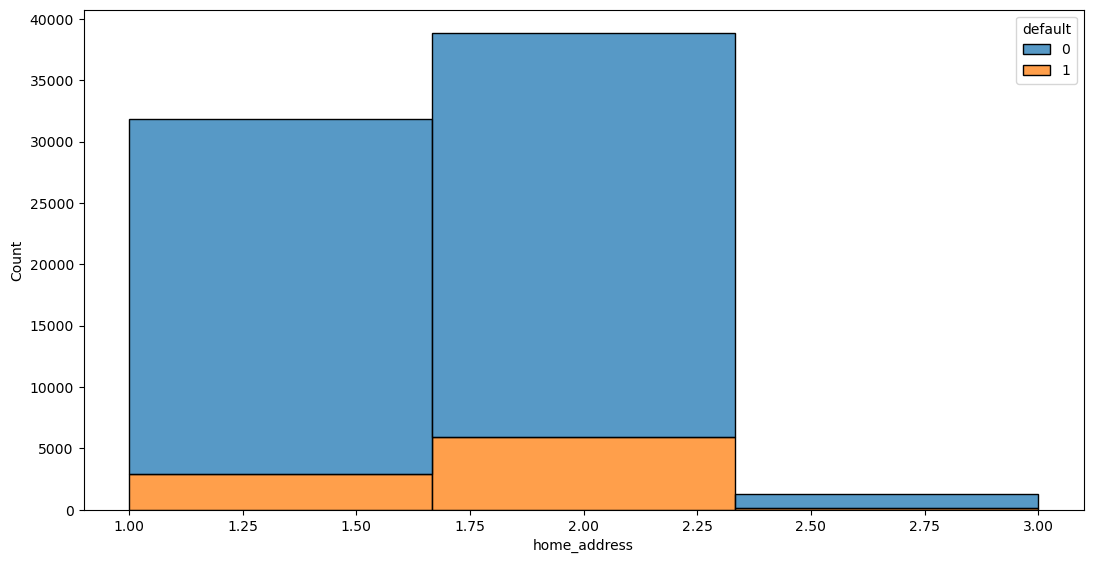

In [43]:
display(train_df['home_address'].value_counts(normalize=True) * 100)
build_histplot(train_df['home_address'], train_df['default'], bins=train_df['home_address'].nunique());

,home_address,default
0,1,0.090643
1,2,0.152118
2,3,0.115977


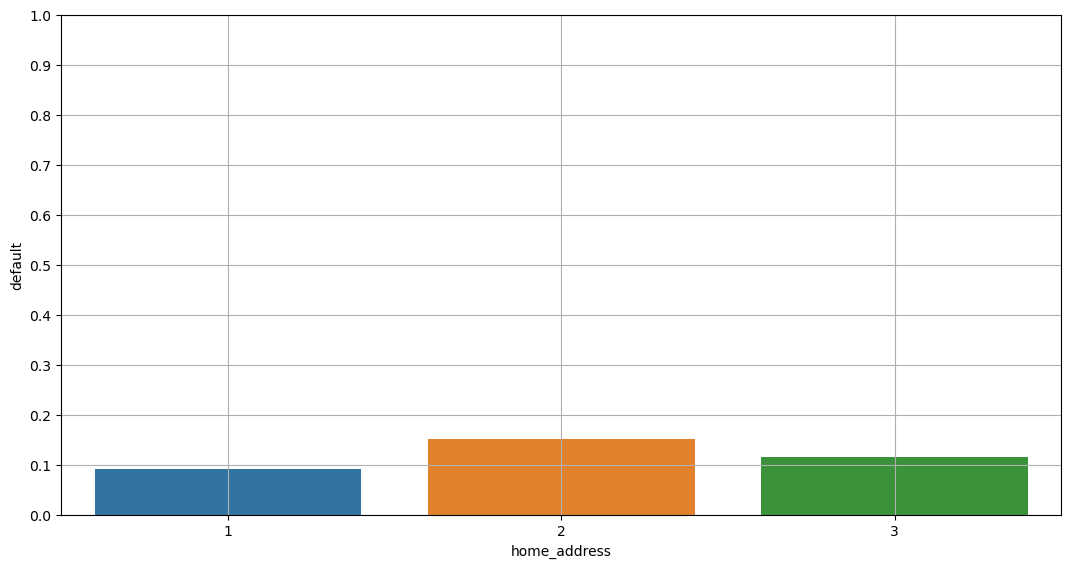

In [44]:
default_by_home_address = train_df.groupby('home_address', as_index=False)['default'].mean()

display(default_by_home_address)
build_barplot(default_by_home_address['home_address'], default_by_home_address['default']);

`home_address` с значением 3 является самым редким в количестве 1.7%, значения 1 и 2 находятся в соотношении 44 к 54 соответственно. Однако процент дефолтов не сильно варьируется от типа к типу. Самый высокий процент у значения 2, после него идёт 3, на последнем месте 1 с соотношениями 15%, 11% и 9% соответственно.

Выбросы тут искать бесполезно, т.к. нет расшифровки значений адреса.

*В будущем закодируем этот признак с помощью `OneHotEncoding`, т.к. вряд ли адрес 1 типа качественно хуже адреса с типом 2.*

In [45]:
one_hot_cols.append('home_address')

### `work_address`

Категоризатор рабочего адреса. Категориальный признак.

Исследуем его, посмотрим соотношение, визуализируем в разрезе дефолт/не-дефолт.

work_address
3    60.809175
2    27.863217
1    11.327609
Name: proportion, dtype: float64

/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/sit

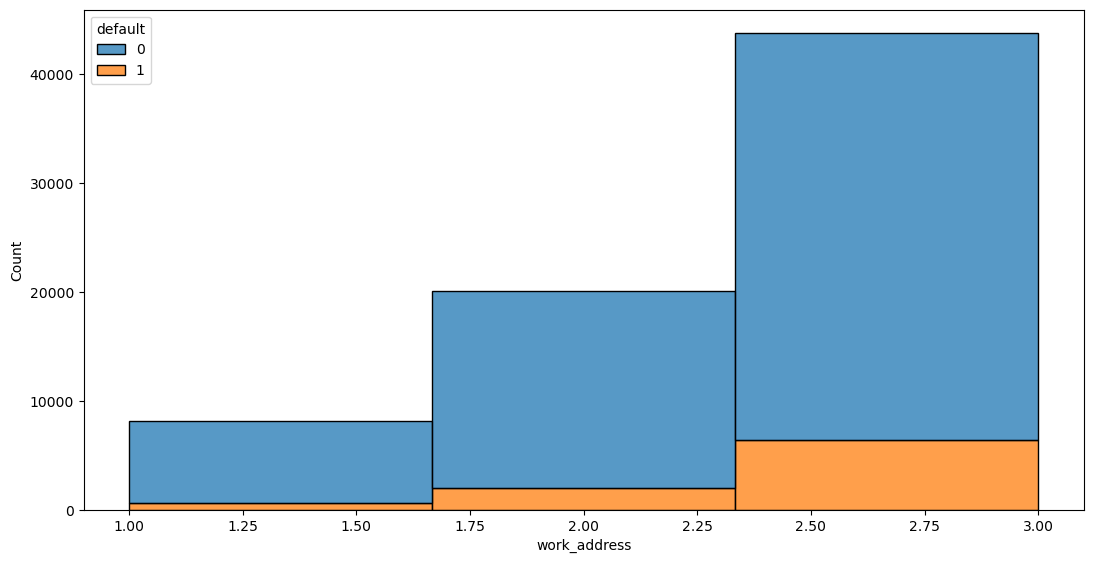

In [46]:
display(train_df['work_address'].value_counts(normalize=True) * 100)
build_histplot(train_df['work_address'], train_df['default'], bins=train_df['work_address'].nunique());

,work_address,default
0,1,0.073596
1,2,0.099401
2,3,0.145130


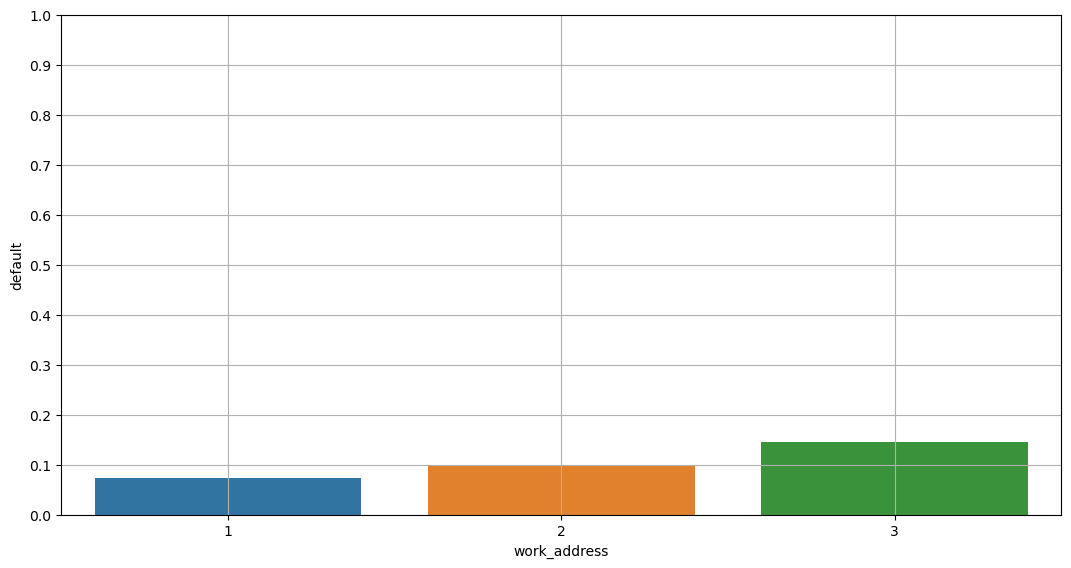

In [47]:
default_by_work_address = train_df.groupby('work_address', as_index=False)['default'].mean()

display(default_by_work_address)
build_barplot(default_by_work_address['work_address'], default_by_work_address['default']);

Из построенных графиков видим, что соотношение типов рабочих адресов близко к 6/3/1 для адресов 3, 2 и 1 типа соответственно. В разрезе дефолт/не-дефолт видится некая зависимость платёжеспособности клиента от типа рабочего адреса - самый малочисленный 1 тип адреса имеет в 2 раза меньший процент дефолтов  по сравнению с 3 типом, который представлен в наибольшем количестве (7% против 14%). 2 тип находится посередине и имеет 10% дефолтов.

Проверим связь этого признака с признаком `good_work`.

,work_address,good_work
0,1,0.195724
1,2,0.148202
2,3,0.166804


/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/sit

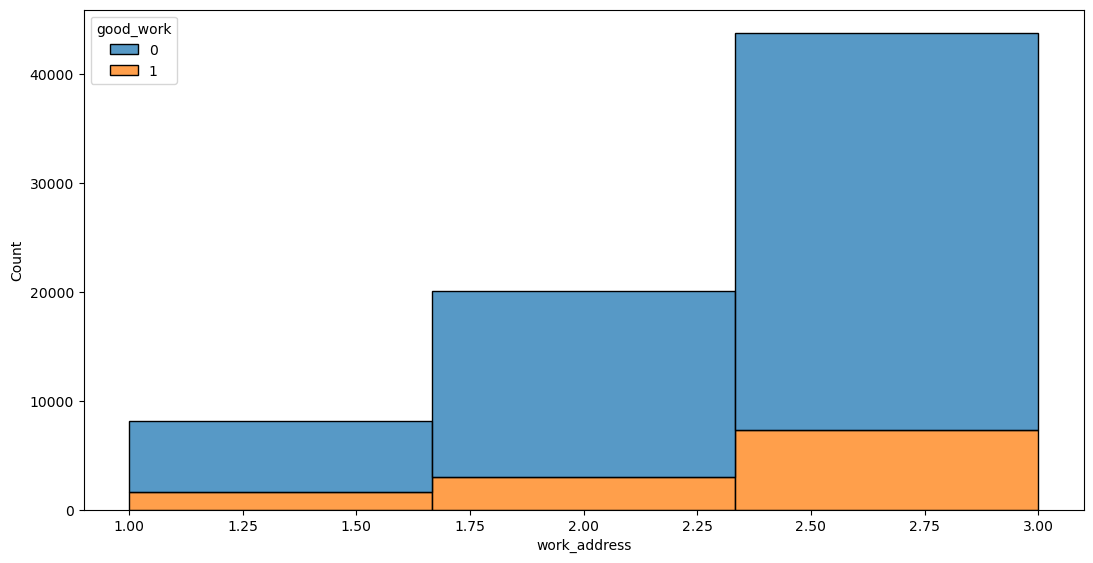

In [48]:
display(train_df.groupby('work_address', as_index=False)['good_work'].mean())
build_histplot(train_df['work_address'], train_df['good_work'], bins=train_df['work_address'].nunique());

"Хорошая" работа чаще встречается у клиентов с 1-м, самым малочисленным, типом рабочего адреса (19%). Но не сказать что это количество значительно выше, чем у двух других типов (15% и 17%)

In [49]:
train_df[['good_work', 'work_address']].corr(method='pearson')

,good_work,work_address
good_work,1.000000,-0.009105
work_address,-0.009105,1.000000


Корреляции между признаками нет.

Выбросы искать тут бесполезно.

*В будущем закодируем признак с помощью `OneHotEncoder`, т.к. неизвестно, является ли тип рабочего адреса 1 качественно хуже типа 2.*

In [50]:
one_hot_cols.append('work_address')

### `income`

Доход заёмщика. Числовой признак.

Исследуем его, визуализируем в разрезе дефолт/не-дефолт, поищем выбросы.

/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/sit

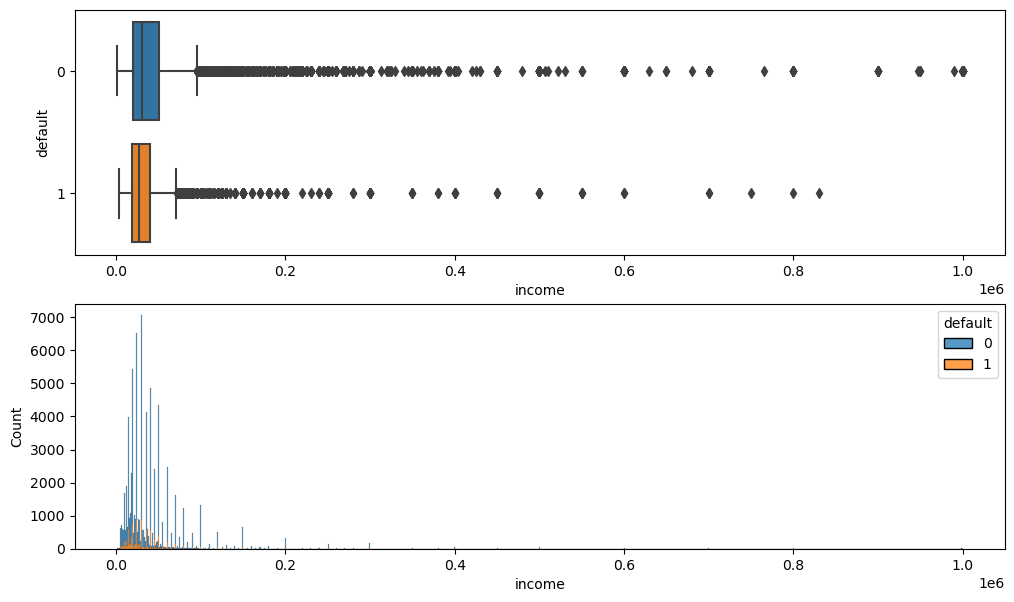

In [51]:
build_distplots(train_df['income'], train_df['default']);

График распределений сконцентрирован около нуля, т.к. есть очень высокие значения (до 1 миллиона). Попробуем сначала поискать выбросы, сопоставляя доход с другими признаками (`good_work`, `work_address`, `age`), чтобы хоть как-то снизить искажения средних значений, после этого попробуем логарифмировать признак.

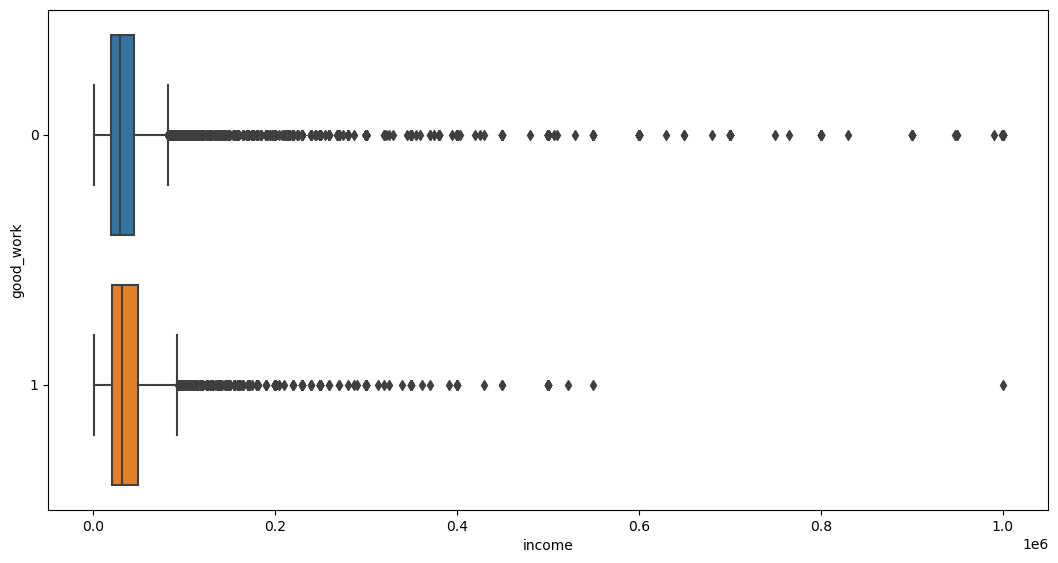

In [52]:
build_boxplot(train_df['income'], train_df['good_work']);

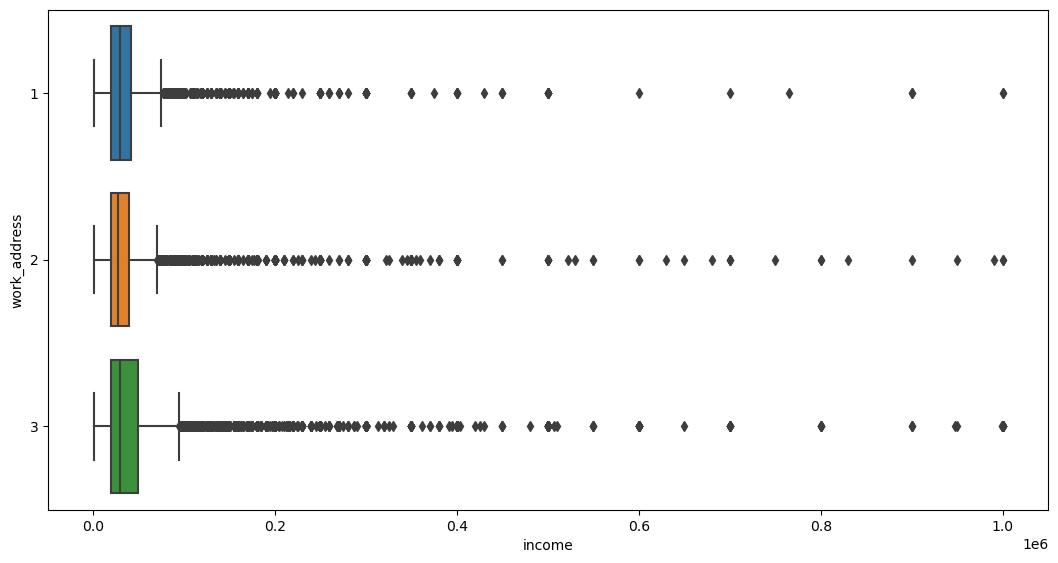

In [53]:
build_boxplot(train_df['income'], train_df['work_address']);

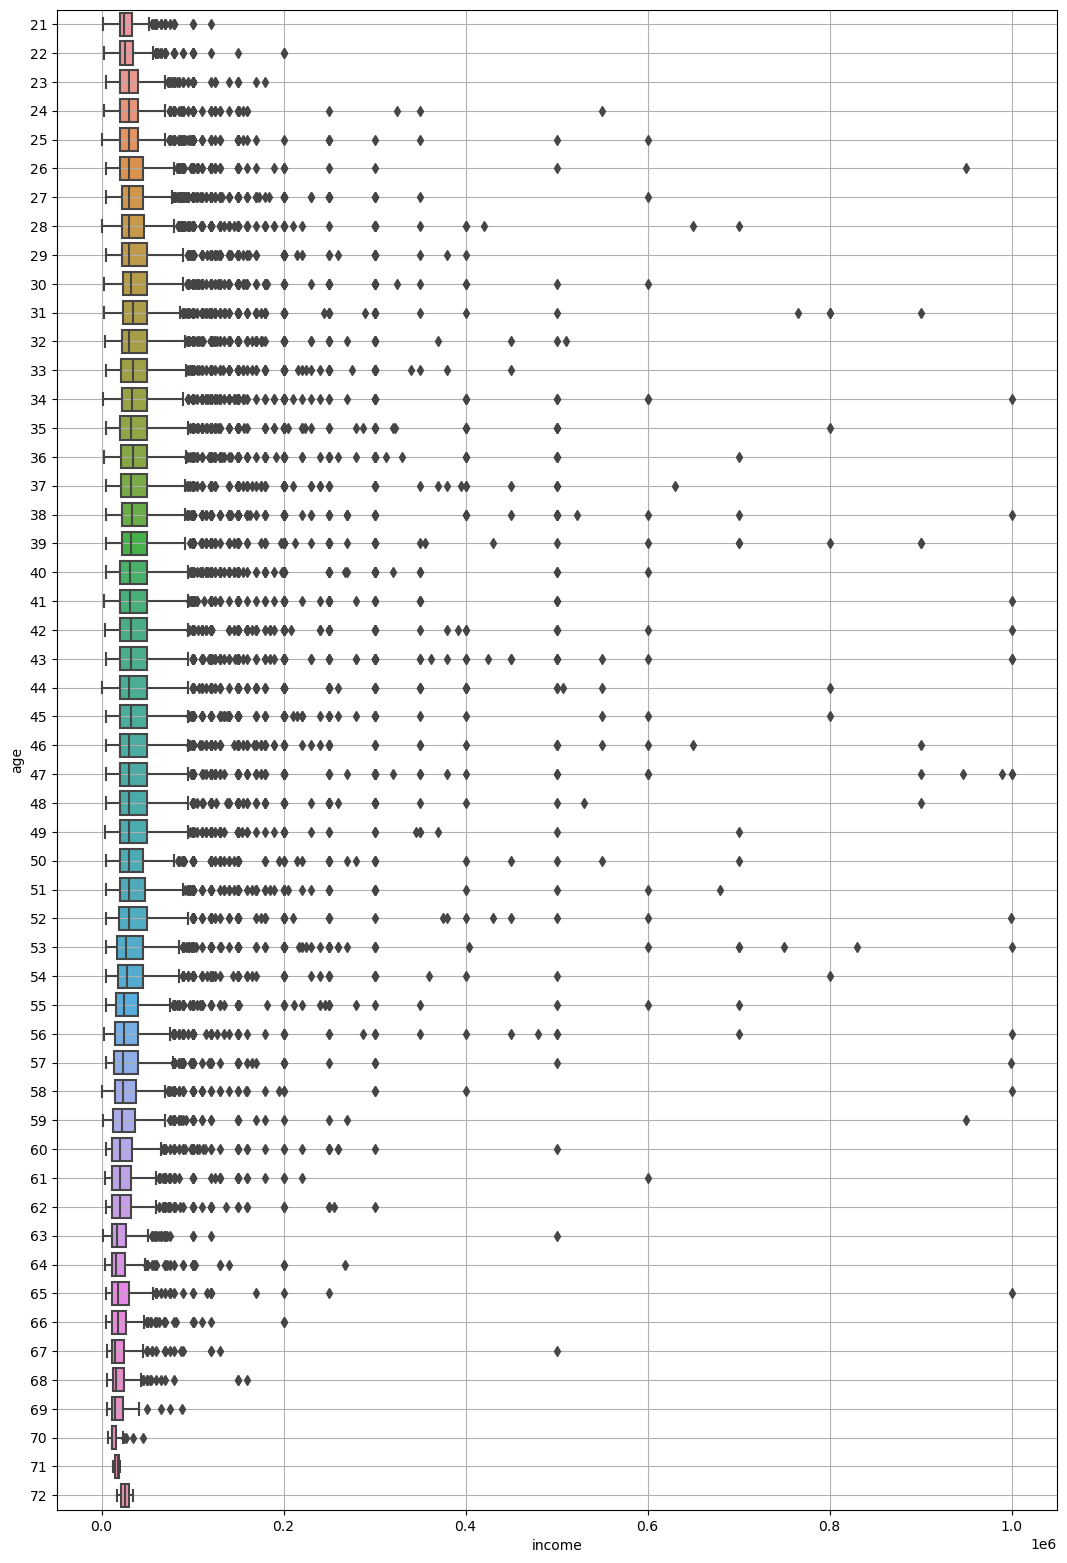

In [54]:
build_boxplot(train_df['income'], train_df['age'], ax=get_axes(figsize=(10, 15))).grid();

Дополнительно построим матрицу корреляций всех этих признаков.

In [55]:
train_df[['income', 'age', 'work_address', 'good_work']].corr(method='pearson')

,income,age,work_address,good_work
income,1.000000,-0.024456,0.048308,0.023445
age,-0.024456,1.000000,-0.006480,-0.077292
work_address,0.048308,-0.006480,1.000000,-0.009105
good_work,0.023445,-0.077292,-0.009105,1.000000


По построенным графикам можно увидеть, что клиенты с "хорошей" работой имеют немного больший медианный заработок, однако количество высоких значений признака больше у клиентов без "хорошей" работы (либо они честнее). Также среди типов рабочих адресов больший медианный заработок имеют клиенты с 3 типом рабочего адреса. В плане высоких значений дохода не прослеживается зависимости от типа рабочего адреса - для всех 3 типов разброс значений примерно одинаковый. Медианный заработок в зависимости от возраста примерно одинаков для всех возрастов, кроме возрастов младше 23 и старше 54, для которых этот показатель немного снижается.

К выбросам потенциально можно отнести клиентов в возрасте 21-24 лет с доходом 200+ тыс. и клиентов с доходом 500+ тыс., т.к. таких людей относительно немного. Оставим эту опцию на будущее как возможность улучшения модели.

Логарифмируем признак и визуализируем его.

/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/sit

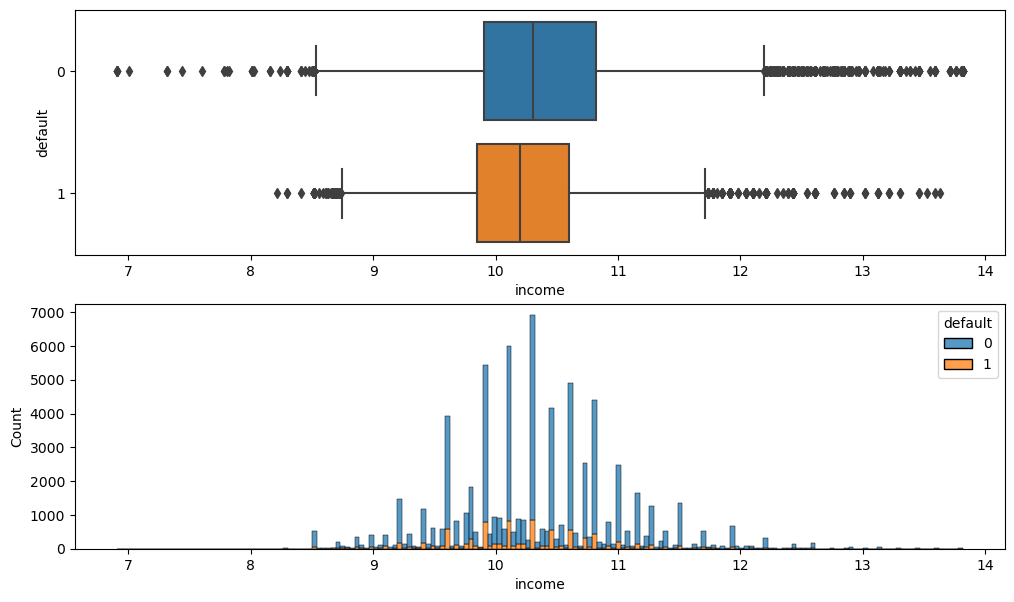

In [56]:
income_log = np.log(train_df['income'])

build_distplots(income_log, train_df['default']);

Проверим распределение логарифмированных данных на нормальность.

In [57]:
check_normal_distribution(income_log);

p-value: 0.9854016657893934 > 0.05. Данные распределены нормально


/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 71851.
  res = hypotest_fun_out(*samples, **kwds)


Будем считать, что данные распределены нормально. Воспользуемся методом z-отклонений для удаления выбросов на логарифмированном признаке.

In [58]:
train_df = train_df.drop(outliers_z_score(income_log).index)

*В дальнейшем применим к этому признаку `StandardScaler`.*

In [59]:
std_cols.append('income')
log_cols.append('income')

### `foreign_passport`

Флаг наличия загранпаспорта у клиента. Бинарный признак.

Визуализируем его в разрезе дефолт/не-дефолт.

foreign_passport
N    85.371433
Y    14.628567
Name: proportion, dtype: float64

/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/sit

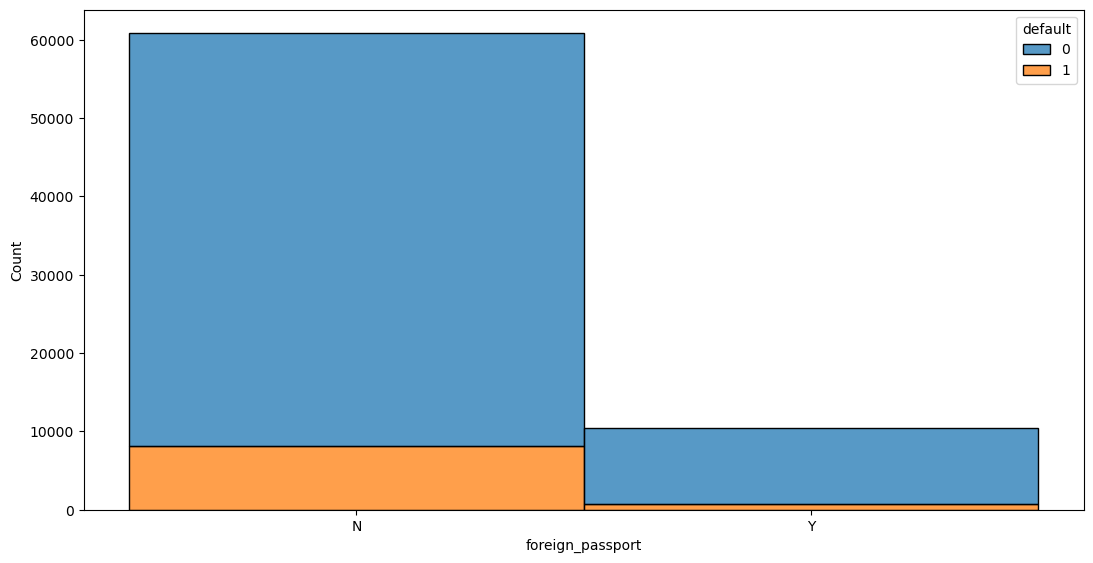

In [60]:
display(train_df['foreign_passport'].value_counts(normalize=True) * 100)
build_histplot(train_df['foreign_passport'], train_df['default']);

,foreign_passport,default
0,N,0.133623
1,Y,0.071189


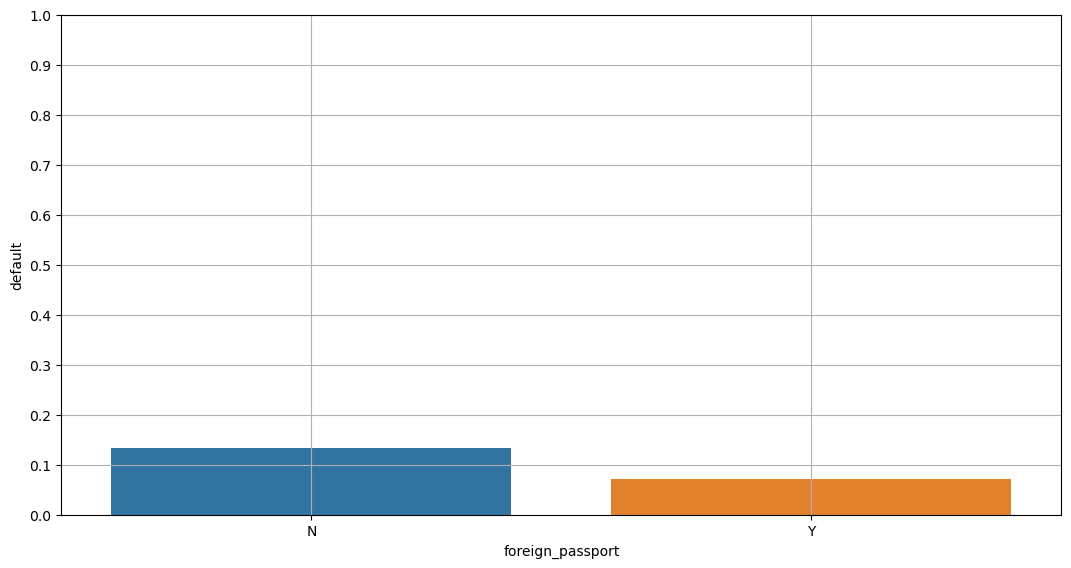

In [61]:
default_by_foreign_passport = train_df.groupby('foreign_passport', as_index=False)['default'].mean()

display(default_by_foreign_passport)
build_barplot(default_by_foreign_passport['foreign_passport'], default_by_foreign_passport['default']);

Из построенных графиков видим, что большая часть клиентов (85%) не имеют загранпаспорта. При этом процент дефолтов у клиентов без загранпаспорта почти в 2 раза выше, чем у клиентов с загранпаспортом (13% против 7%).

*В будущем перекодируем этот признак в цифровой формат.*

In [62]:
bin_cols.append('foreign_passport')

### `sna`

Связь заемщика с клиентами банка. Категориальный признак.

Признак уже закодирован в цифровом формате. К сожалению, расшифровки для каждой категории нет. Визуализируем их в разрезе дефолт/не-дефолт.

sna
1    64.035592
4    15.984337
2    14.388570
3     5.591500
Name: proportion, dtype: float64

/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/sit

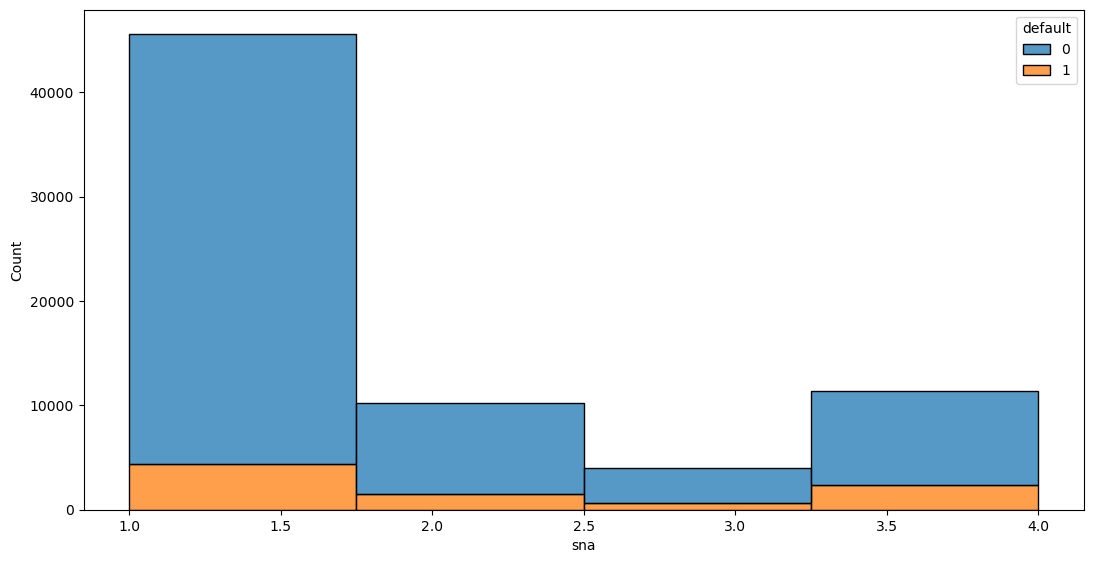

In [63]:
display(train_df['sna'].value_counts(normalize=True) * 100)
build_histplot(train_df['sna'], train_df['default'], bins=train_df['sna'].nunique());

,sna,default
0,1,0.095954
1,2,0.147483
2,3,0.153865
3,4,0.207832


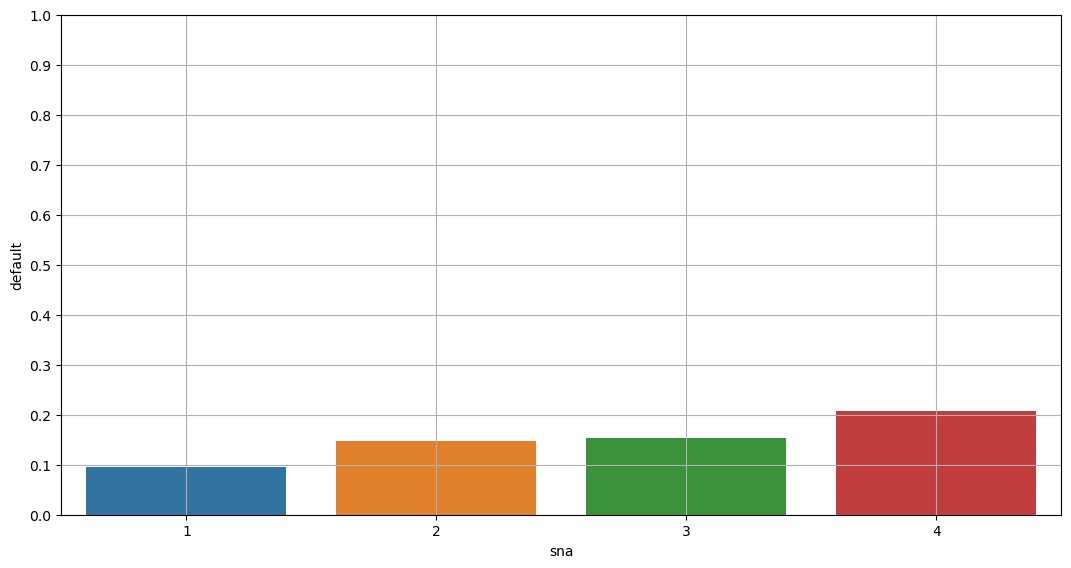

In [64]:
default_by_sna = train_df.groupby('sna', as_index=False)['default'].mean()

display(default_by_sna)
build_barplot(default_by_sna['sna'], default_by_sna['default']);

Из построенных графиков видим, что соотношение категорий 1/2/3/4 примерно 65/15/5/15. Прослеживается некоторая зависимость платёжеспособности клиента от категории. Самая многочисленная категория (1) имеет самый низкий процент дефолтов (10%), а категория 4 имеет дефолт в 2 раза чаще (20%). Две другие категории имеют около 15% дефолтов.

*Закодируем этот признак в будущем с помощью `OneHotEncoding`, т.к. нет информации о том, является ли 1 категория качественно хуже 2, 3 или 4.*

In [65]:
one_hot_cols.append('sna')

### `first_time`

Давность наличия информации о заемщике. Категориальный признак.

К сожалению, информация о значении каждой категории не предоставлена. Визуализируем его в разрезе дефолт/не-дефолт.

first_time
3    42.340458
4    25.272628
1    16.687485
2    15.699429
Name: proportion, dtype: float64

/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/sit

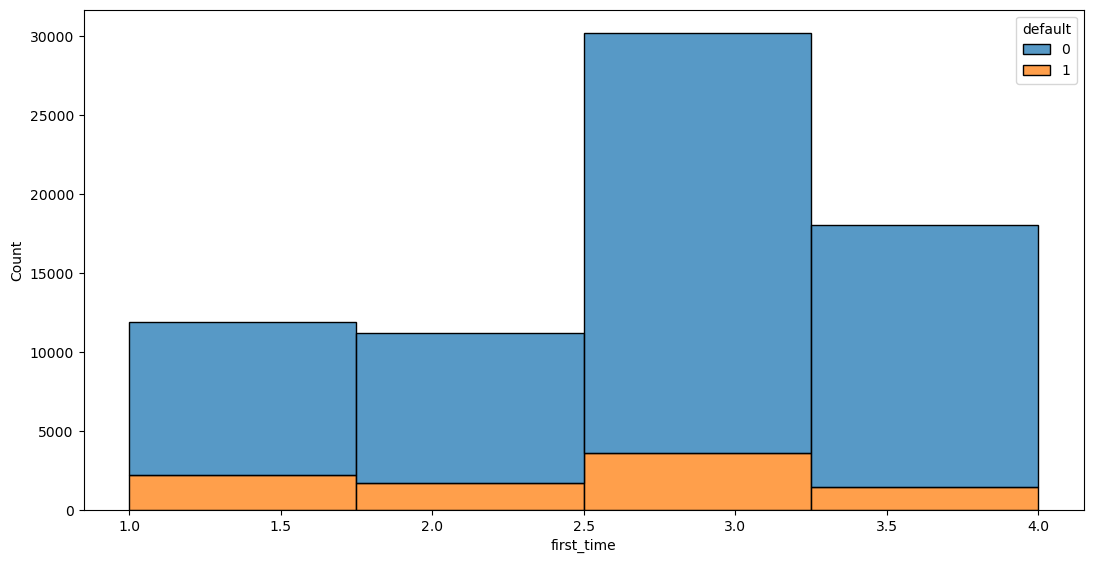

In [66]:
display(train_df['first_time'].value_counts(normalize=True) * 100)
build_histplot(train_df['first_time'], train_df['default'], bins=train_df['first_time'].nunique());

,first_time,default
0,1,0.183263
1,2,0.152065
2,3,0.118006
3,4,0.079414


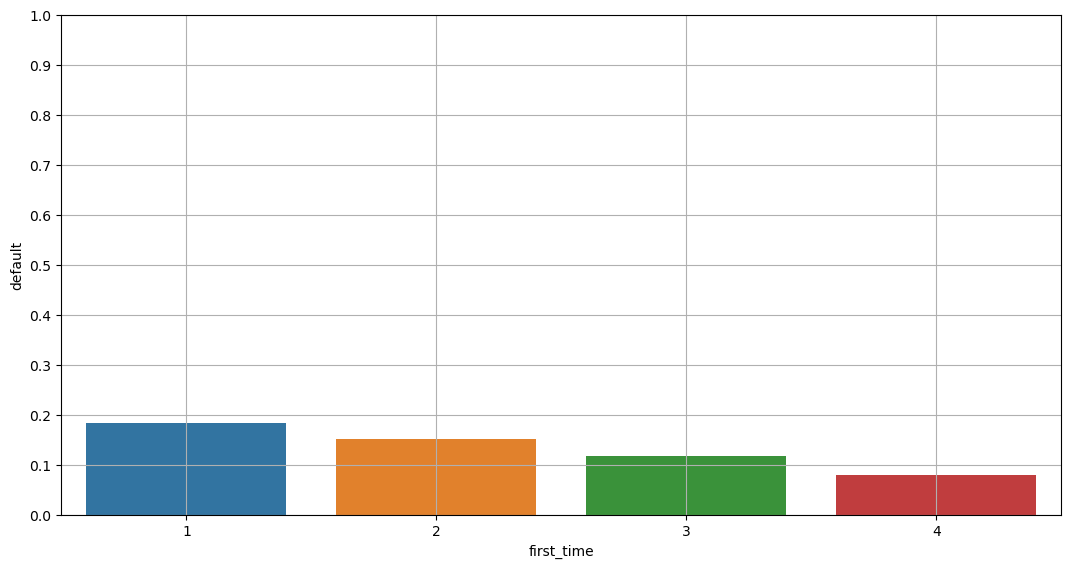

In [67]:
default_by_first_time = train_df.groupby('first_time', as_index=False)['default'].mean()

display(default_by_first_time)
build_barplot(default_by_first_time['first_time'], default_by_first_time['default']);

Из графиков и таблиц видим, что соотношение категорий клиентов 1/2/3/4 примерно 17/16/42/25. При этом прослеживается связь между платёжеспособностью клиента и этим признаком. Для категории 1 доля дефолтов достигает 18%, в то время как для категории 4 этот показатель составляет 8%. Для категорий 2 и 3 доля дефолтов соответственно 15% и 12%.

*В будущем дополнительно закодируем этот признак с помощью `OneHotEncoding`, т.к. неизвестно, является ли признак с значением 1 качественно хуже признака с значением 2+*

In [68]:
one_hot_cols.append('first_time')

### `score_bki`

Скоринговый балл по данным из БКИ. Числовой признак.

Исследуем его, визуализируем в разрезе дефолт/не-дефолт, проверим связь показателя с `bki_request_cnt`.

/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/sit

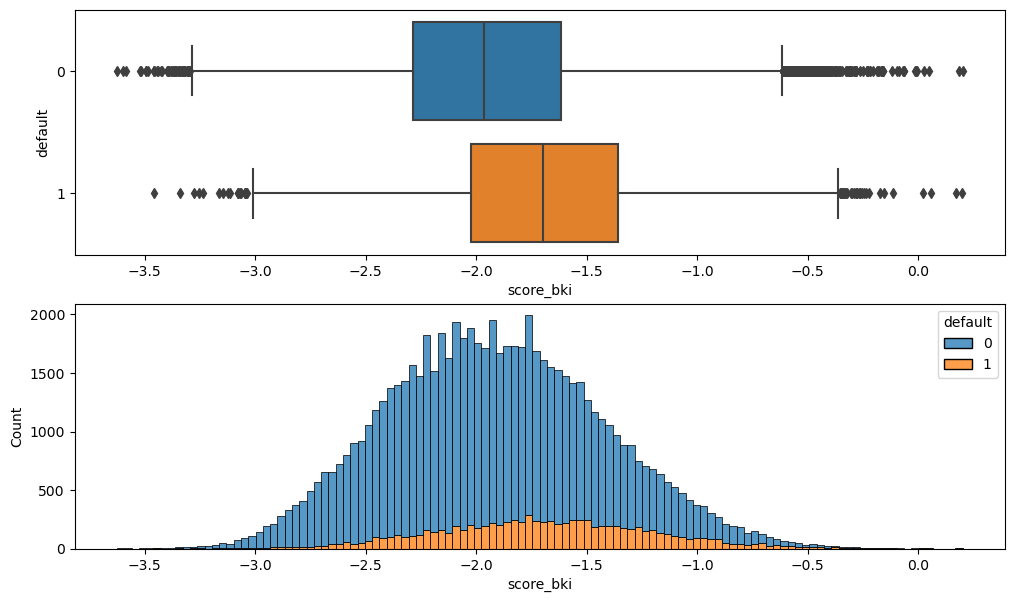

In [69]:
build_distplots(train_df['score_bki'], train_df['default']);

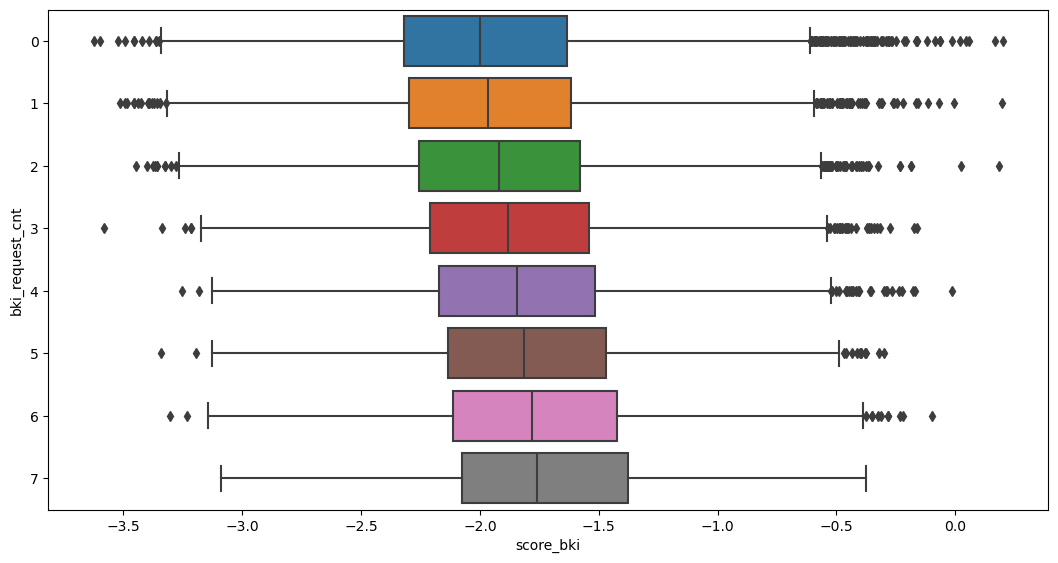

In [70]:
build_boxplot(train_df['score_bki'], train_df['bki_request_cnt']);

Проверим распределение на нормальность.

In [71]:
check_normal_distribution(train_df['score_bki']);

p-value: 0.9973610413901356 > 0.05. Данные распределены нормально


/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 71251.
  res = hypotest_fun_out(*samples, **kwds)


Следуя выводам из теста и смотря на график распределения, будем считать, что имеем дело с данными, близким к нормальному распределению. Также на гистограмме и боксплотах видим, что у дефолтных клиентов в среднем рейтинг ближе к 0, чем у не-дефолтных. Помимо этого видим связь с признаком `bki_request_cnt` - чем больше количество заявок, тем ниже средний рейтинг клиентов.

Т.к. распределение данных близко к нормальному, произведём очистку от выбросов методом z-отклонений.

In [72]:
train_df = train_df.drop(outliers_z_score(train_df['score_bki']).index)

*В будущем осуществим преобразование признака с помощью `StandardScaler`.*

In [73]:
std_cols.append('score_bki')

### `region_rating`

Рейтинг региона. Категориальный признак.

Визуализируем его в разрезе дефолт/не-дефолт, оценим соотношение. Вероятно может присутствовать связь с другими показателями (`income`, `good_work`, `age`, `home_address`, `work_address`, `score_bki`)

region_rating
50    37.523735
60    21.830124
40    16.417952
80    15.281509
70     8.257500
30     0.410695
20     0.278485
Name: proportion, dtype: float64

/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/sit

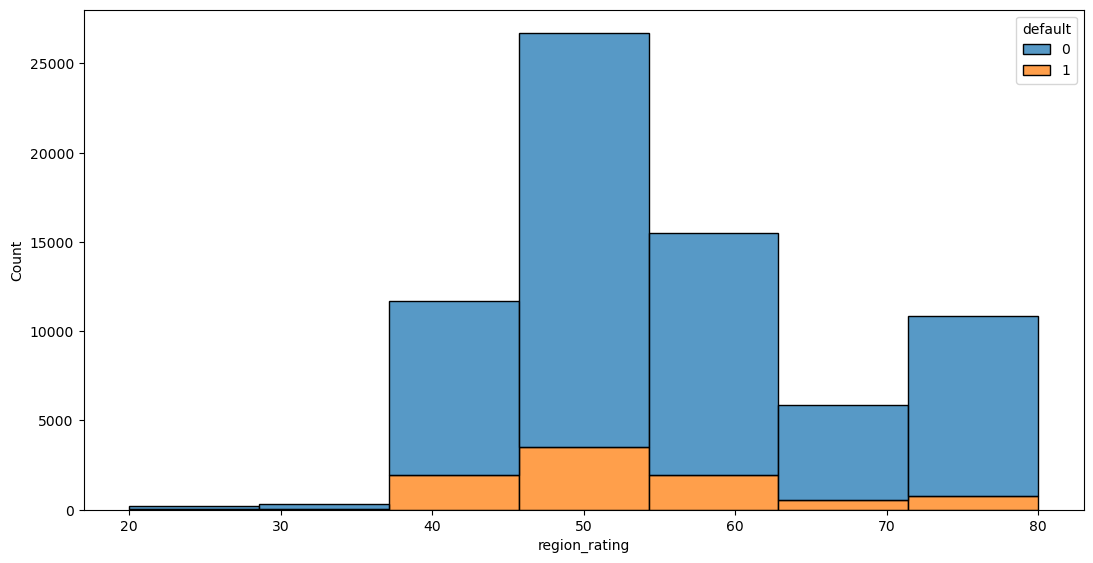

In [74]:
display(train_df['region_rating'].value_counts(normalize=True) * 100)
build_histplot(train_df['region_rating'], train_df['default'], bins=train_df['region_rating'].nunique());

,region_rating,default
0,20,0.212121
1,30,0.195205
2,40,0.166795
3,50,0.131901
4,60,0.125958
5,70,0.089934
6,80,0.071238


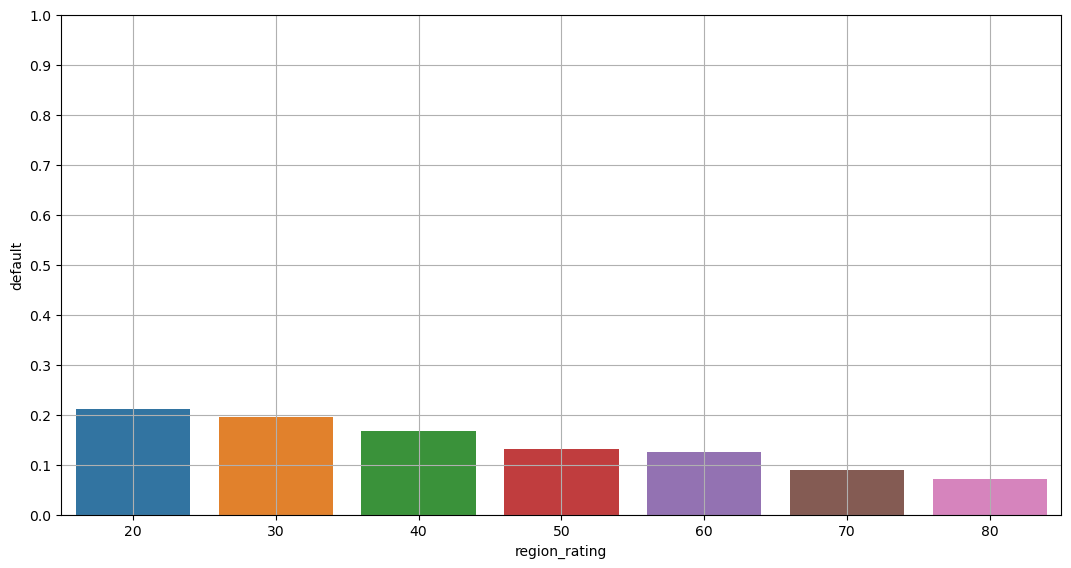

In [75]:
default_by_region_rating = train_df.groupby('region_rating', as_index=False)['default'].mean()

display(default_by_region_rating)
build_barplot(default_by_region_rating['region_rating'], default_by_region_rating['default']);

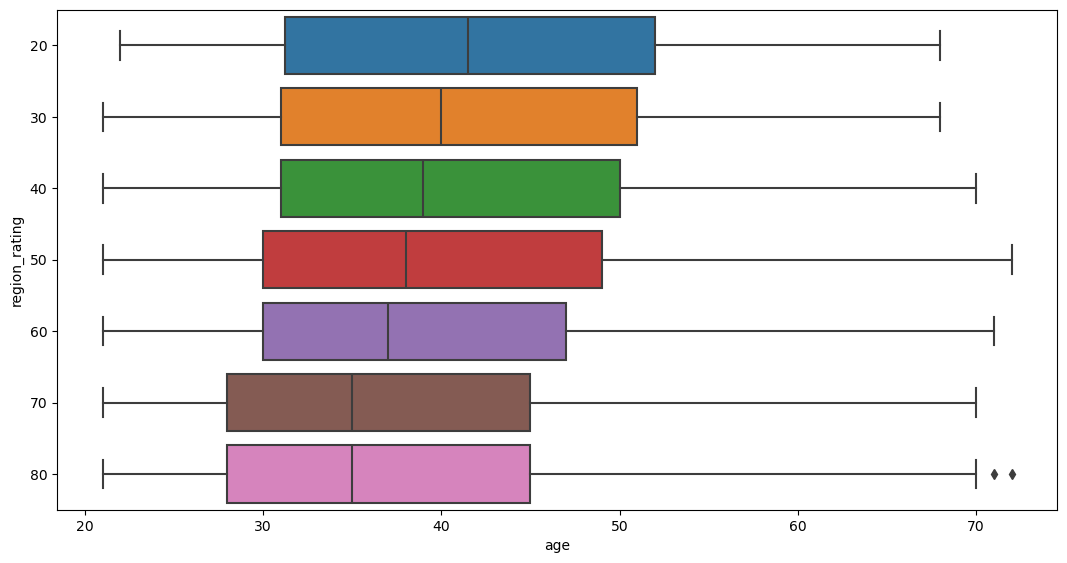

In [76]:
build_boxplot(train_df['age'], train_df['region_rating']);

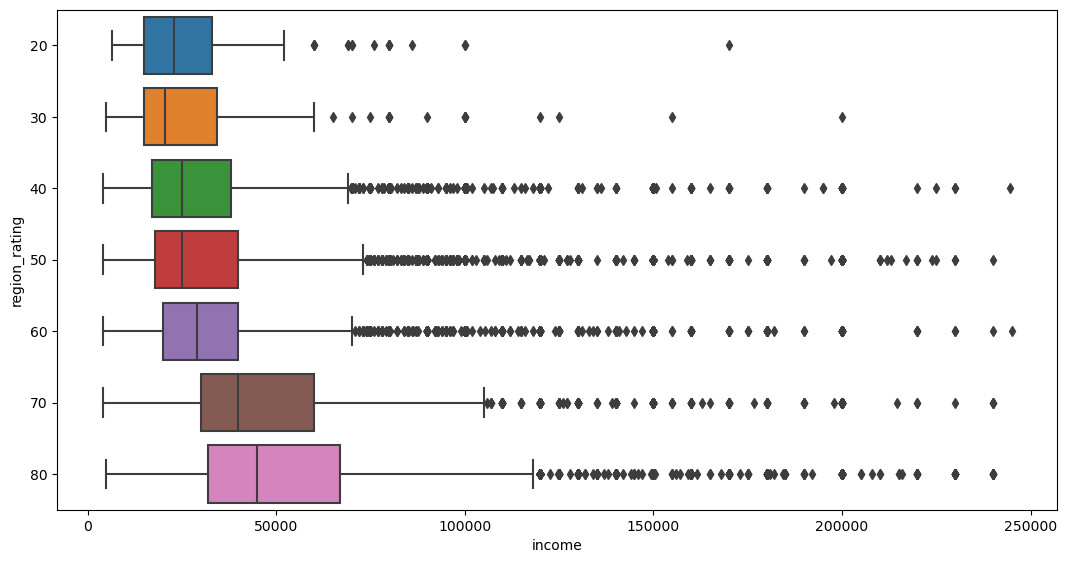

In [77]:
build_boxplot(train_df['income'], train_df['region_rating']);

,region_rating,good_work
0,20,0.267677
1,30,0.184932
2,40,0.147777
3,50,0.143559
4,60,0.157786
5,70,0.191279
6,80,0.230097


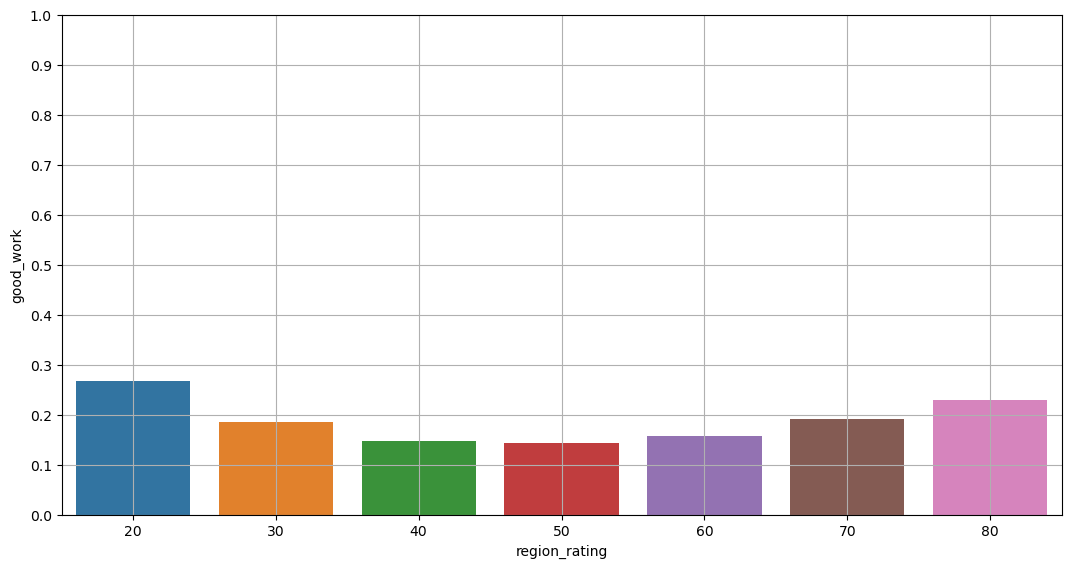

In [78]:
good_work_by_region_rating = train_df.groupby('region_rating', as_index=False)['good_work'].mean()

display(good_work_by_region_rating)
build_barplot(good_work_by_region_rating['region_rating'], good_work_by_region_rating['good_work']);

Мы могли бы исследовать связь `region_rating` с `home_address` и `work_address`, однако из-за отсутствия информации по данным признакам, это имеет мало смысла.

In [79]:
# train_df['region_home_address_fraction'] = train_df.groupby(['home_address', 'region_rating'])['home_address'].transform('count') / train_df.groupby('region_rating')['region_rating'].transform('count') * 100

# display(np.round(train_df.groupby(['region_rating', 'home_address'], as_index=False)['region_home_address_fraction'].mean(), 2))
# build_histplot(train_df['region_rating'], train_df['home_address'], bins=train_df['region_rating'].nunique(), palette='flare');

# train_df = train_df.drop('region_home_address_fraction', axis=1)

In [80]:
# train_df['region_work_address_fraction'] = train_df.groupby(['work_address', 'region_rating'])['work_address'].transform('count') / train_df.groupby('region_rating')['region_rating'].transform('count') * 100

# display(np.round(train_df.groupby(['region_rating', 'work_address'], as_index=False)['region_work_address_fraction'].mean(), 2))
# build_histplot(train_df['region_rating'], train_df['work_address'], bins=train_df['region_rating'].nunique(), palette='flare');

# train_df = train_df.drop('region_work_address_fraction', axis=1)

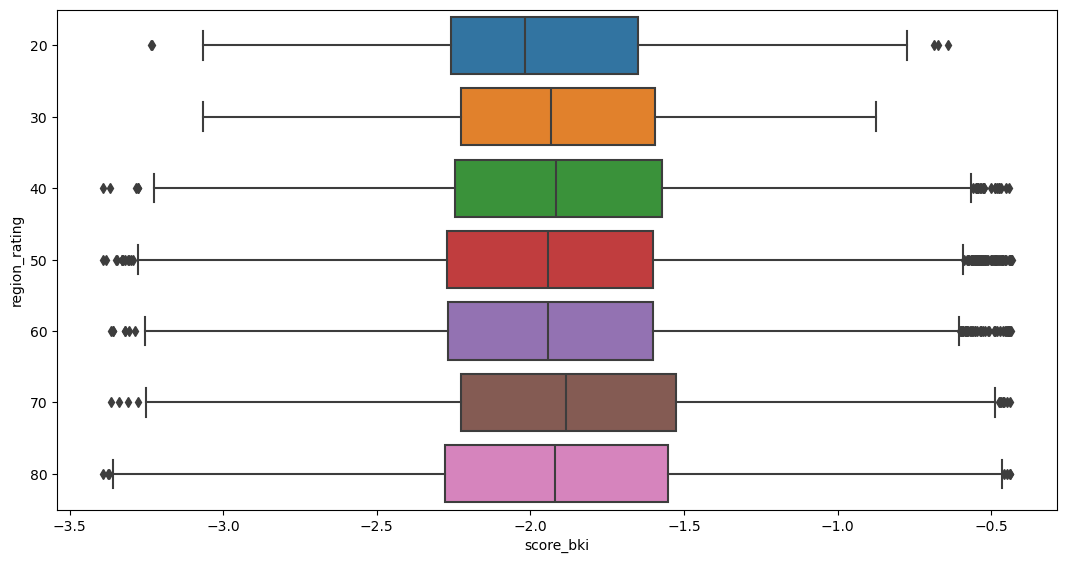

In [81]:
build_boxplot(train_df['score_bki'], train_df['region_rating']);

По построенным графикам можем видеть, что наименьшее количество клиентов (<1%) находится в регионах с рейтингом 20 и 30, большая часть (около 75%) сосредоточена в регионах с рейтингом 40-60, оставшаяся часть находится в регионах с рейтингом 70-80.

Прослеживается зависимость, что чем выше рейтинг региона, тем меньше в нём доля дефолтных клиентов - почти 20% в регионе с рейтингом 20 и постепенное снижение до 7% в регионе с рейтингом 80.

С повышением рейтинга региона повышаются и средние доходы клиентов, а также понижается средний возраст клиента.

По флагу "хорошей" работы можно сделать вывод, что в регионах с низким и высоким рейтингом доля клиентов с "хорошей" работой выше, чем в регионах со средним рейтингом.

Средний рейтинг БКИ от региона к региону не сильно меняется, поэтому сложно проследить какую-то зависимость, кроме того, что в регионе с рейтингом 20 средний рейтинг БКИ дальше от нуля по сравнению с остальными. Но и разброс значений там меньше. Разброс в регионе с рейтингом 30 аналогичен, а средние значения ближе к нулю.

*В будущем произведём кодировку с помощью `OneHotEncoder`.*

*Потенциальный вариант улучшения качества модели - сокращение количества категорий до 3 (20-30: низкий, 40-60: средний, 70-80: высокий)*

In [82]:
one_hot_cols.append('region_rating')

### `app_date`

Дата подачи заявки.

Приведём признак к формату даты и исследуем его.

In [83]:
train_df['app_date'] = pd.to_datetime(train_df['app_date'])
train_df[['app_date']].describe()

/tmp/ipykernel_23441/989756622.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_df['app_date'] = pd.to_datetime(train_df['app_date'])


,app_date
count,71099
mean,2014-03-03 04:58:17.568179712
min,2014-01-01 00:00:00
25%,2014-02-03 00:00:00
50%,2014-03-04 00:00:00
75%,2014-03-31 00:00:00
max,2014-04-30 00:00:00


Данные приведены за 120 дней с 1 января по 30 апреля. Проверим их распределение в разрезе дефолт/не-дефолт.

/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ilya/miniconda3/envs/SOBES/lib/python3.13/sit

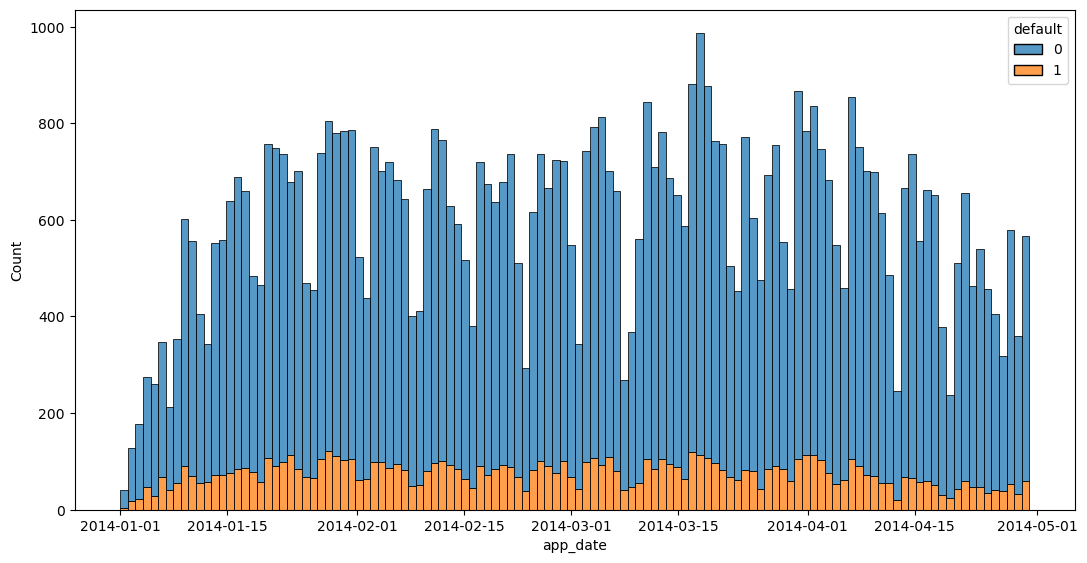

In [84]:
build_histplot(train_df['app_date'], train_df['default'], bins=train_df['app_date'].nunique());

,app_date,default
0,2014-01-01,0.097561
1,2014-01-02,0.140625
2,2014-01-03,0.123596
3,2014-01-04,0.167273
4,2014-01-05,0.111538
...,...,...
115,2014-04-26,0.098765
116,2014-04-27,0.119122
117,2014-04-28,0.091537
118,2014-04-29,0.091922


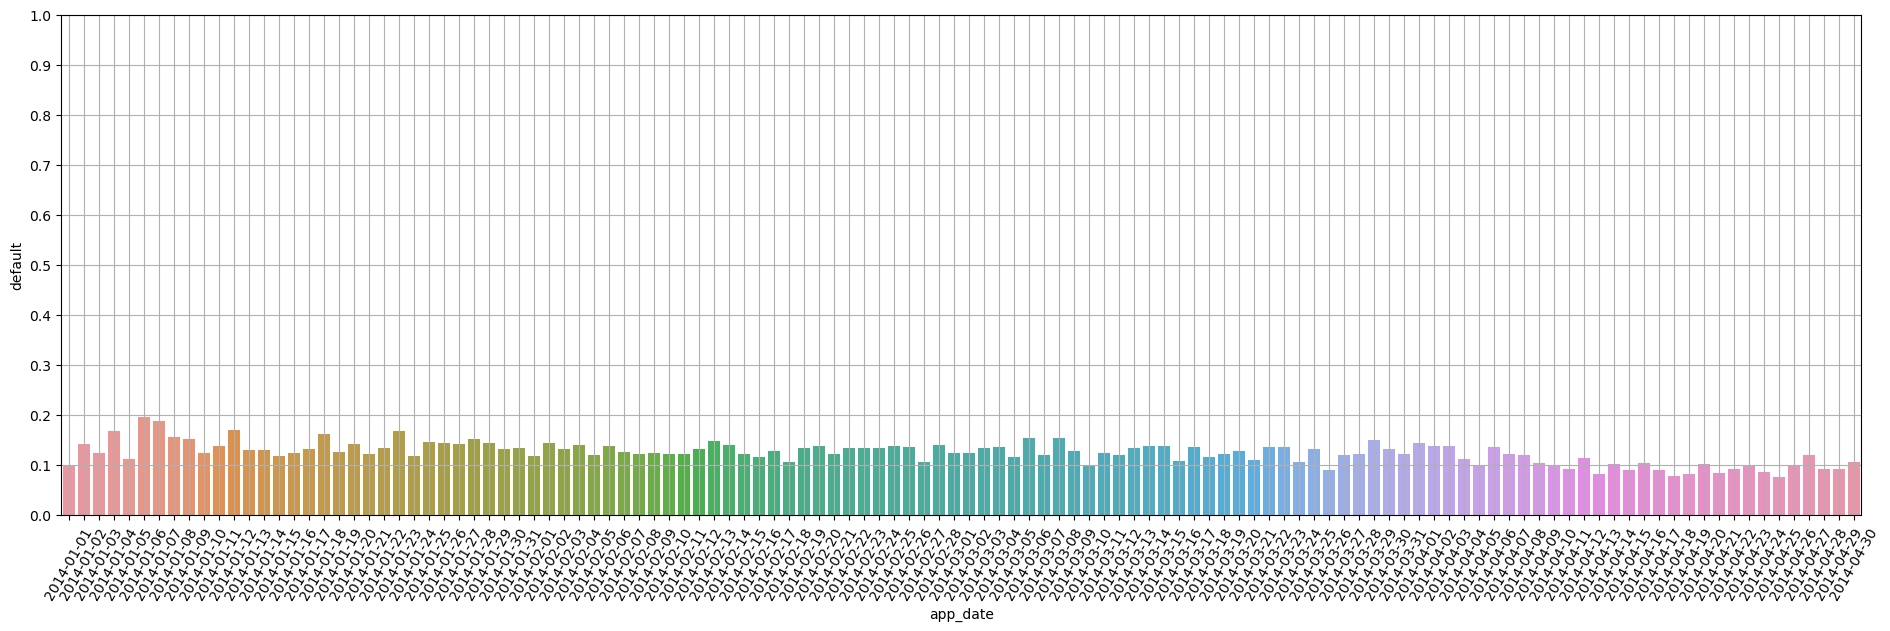

In [85]:
default_by_app_date = train_df.groupby('app_date', as_index=False)['default'].mean()

display(default_by_app_date)
build_barplot(default_by_app_date['app_date'].dt.date, default_by_app_date['default'], figsize=(18, 5)).tick_params('x', labelrotation=60);


Из построенных графиков видим, что ближе зимой общее количество заявок немного меньше, чем весной. К концу марта количество заявок немного увеличивается. Можно было предположить, что в предпраздничные дни количество заявок может увеличиваться, но из графиков никакой зависимости от дат не прослеживается (за исключением естественного проседания каждые в выходные).
В начале января есть небольшой скачок дефолтных клиентов, но дальше график идёт примерно одинаково и доля дефолтных клиентов варьируется в районе 10-15% вне зависимости от даты подачи. Также видим, что доля дефолтных клиентов с датой подачи заявки в апреле ниже, чем в январе. Попробуем разделить клиентов по месяцам подачи заявки.

,app_month,default
0,1,0.139141
1,2,0.128537
2,3,0.124749
3,4,0.104566


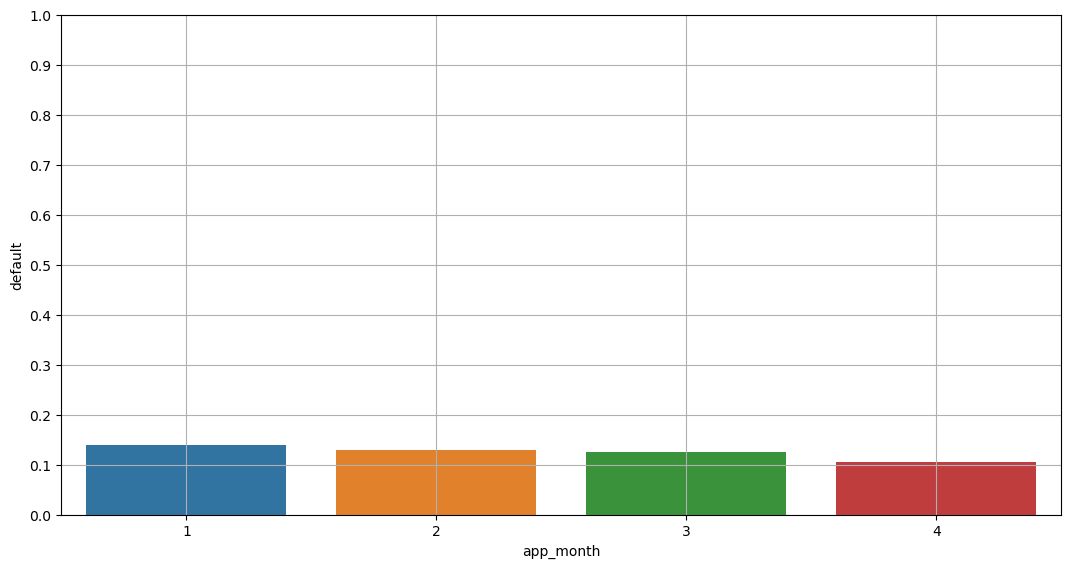

In [86]:
train_df['app_month'] = train_df['app_date'].dt.month

default_by_app_month = train_df.groupby('app_month', as_index=False)['default'].mean()
display(default_by_app_month)
build_barplot(default_by_app_month['app_month'], default_by_app_month['default']);

Из построенного графика видим, что доля дефолтных клиентов с датой подачи заявки в апреле ниже. Однако, вряд ли этот факт можно считать чем-то значимым, т.к. у нас отсутствуют данные за остальные месяцы.

*Делаем вывод, что данный признак бесполезен для нашей модели, поэтому удалим его, а также в будущем удалим признак даты подачи заявки*

In [87]:
train_df = train_df.drop('app_month', axis=1)
cols_to_delete.append('app_date')

In [88]:
print(std_cols)
print(robust_cols)
print(one_hot_cols)
print(ordinal_cols)
print(bin_cols)
print(cols_to_delete)

['age', 'income', 'score_bki']
['decline_app_cnt', 'bki_request_cnt']
['education', 'home_address', 'work_address', 'sna', 'first_time', 'region_rating']
[]
['sex', 'good_work', 'foreign_passport']
['client_id', 'car', 'car_type', 'app_date']


Реализуем все выводы выше о преобразованиях признаков в функции-трансформере и применим её на тренировочном и тестовом наборах.

In [89]:
display(
    train_df.head(),
    train_df.describe(),
    train_df.describe(include=['object']),
    train_df.info(),
    std_cols,
    robust_cols,
    one_hot_cols,
    ordinal_cols,
    bin_cols,
    cols_to_delete,
)

<class 'pandas.core.frame.DataFrame'>
Index: 71099 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   client_id         71099 non-null  int64         
 1   app_date          71099 non-null  datetime64[ns]
 2   education         71099 non-null  object        
 3   sex               71099 non-null  object        
 4   age               71099 non-null  int64         
 5   car               71099 non-null  object        
 6   car_type          71099 non-null  object        
 7   decline_app_cnt   71099 non-null  int64         
 8   good_work         71099 non-null  int64         
 9   score_bki         71099 non-null  float64       
 10  bki_request_cnt   71099 non-null  int64         
 11  region_rating     71099 non-null  int64         
 12  home_address      71099 non-null  int64         
 13  work_address      71099 non-null  int64         
 14  income            71099 non

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,2014-02-01,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,2014-01-23,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,2014-04-18,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


,client_id,app_date,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,71099.000000,71099,71099.000000,71099.000000,71099.000000,71099.000000,71099.000000,71099.000000,71099.000000,71099.000000,71099.000000,71099.000000,71099.000000,71099.000000
mean,55306.770573,2014-03-03 04:58:17.568179712,39.245615,0.239089,0.165037,-1.915513,1.777311,56.611485,1.573876,2.494184,37844.970745,1.735200,2.762064,0.124081
min,1.000000,2014-01-01 00:00:00,21.000000,0.000000,0.000000,-3.392446,0.000000,20.000000,1.000000,1.000000,4000.000000,1.000000,1.000000,0.000000
25%,27609.500000,2014-02-03 00:00:00,30.000000,0.000000,0.000000,-2.264599,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000
50%,55523.000000,2014-03-04 00:00:00,37.000000,0.000000,0.000000,-1.928639,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000
75%,82930.500000,2014-03-31 00:00:00,48.000000,0.000000,0.000000,-1.582933,3.000000,60.000000,2.000000,3.000000,45000.000000,2.000000,4.000000,0.000000
max,110147.000000,2014-04-30 00:00:00,72.000000,5.000000,1.000000,-0.433124,7.000000,80.000000,3.000000,3.000000,245000.000000,4.000000,4.000000,1.000000
std,31828.543676,NaN,11.546143,0.642511,0.371217,0.488137,1.670109,13.009667,0.528130,0.690230,29201.098651,1.125064,1.010312,0.329676


,education,sex,car,car_type,foreign_passport
count,71099,71099,71099,71099,71099
unique,5,2,2,2,2
top,SCH,F,N,N,N
freq,38016,40111,48299,57975,60706


None

['age', 'income', 'score_bki']

['decline_app_cnt', 'bki_request_cnt']

['education',
 'home_address',
 'work_address',
 'sna',
 'first_time',
 'region_rating']

[]

['sex', 'good_work', 'foreign_passport']

['client_id', 'car', 'car_type', 'app_date']

In [90]:
def transform_features(data, transformers, fit=False):
    result = data.copy()
    
    car_filter = data['car'] == 'Y'
    foreign_car_filter = data['car_type'] == 'Y'
    result['has_domestic_car'] = (car_filter & ~foreign_car_filter).astype('uint8')
    result['has_foreign_car'] = (car_filter & foreign_car_filter).astype('uint8')
    
    for col in log_cols:
        result[col] = np.log(result[col])
    
    for col in na_fill_values:
        result[col] = result[col].fillna(na_fill_values[col])
    
    for transformer, cols in transformers:
        if fit: transformer.fit(result[cols])
            
        result[
            transformer.get_feature_names_out(cols) if hasattr(transformer, 'get_feature_names_out') else cols
        ] = transformer.transform(result[cols])

    return result

Подготовим энкодеры/скейлеры, преобразуем данные и разделим датасет и целевую переменную.

In [91]:
ordinal_encoder = OrdinalEncoder(
    categories=[
        ['SCH', 'UGR', 'GRD', 'PGR', 'ACD'],
        [20, 30, 40, 50, 60, 70, 80]
    ],
    dtype='uint8'
)
one_hot_encoder = OneHotEncoder(sparse_output=False, dtype='uint8')
print(type(one_hot_encoder))
bin_encoder = OrdinalEncoder(dtype='uint8')
std_scaler = StandardScaler()
robust_scaler = RobustScaler()

transformers = [
    (one_hot_encoder, one_hot_cols),
    (bin_encoder, bin_cols),
    (std_scaler, std_cols),
    (robust_scaler, robust_cols),
]

X = transform_features(train_df, transformers, fit=True).drop(cols_to_delete + one_hot_cols + ['default'], axis=1)
y = train_df['default']

<class 'sklearn.preprocessing._encoders.OneHotEncoder'>


Построим матрицу корреляций для числовых и категориальных признаков, проверим данные на мультиколлинеарность. Будем использовать корреляции Пирсона и Спирмена для соответствующих признаков.

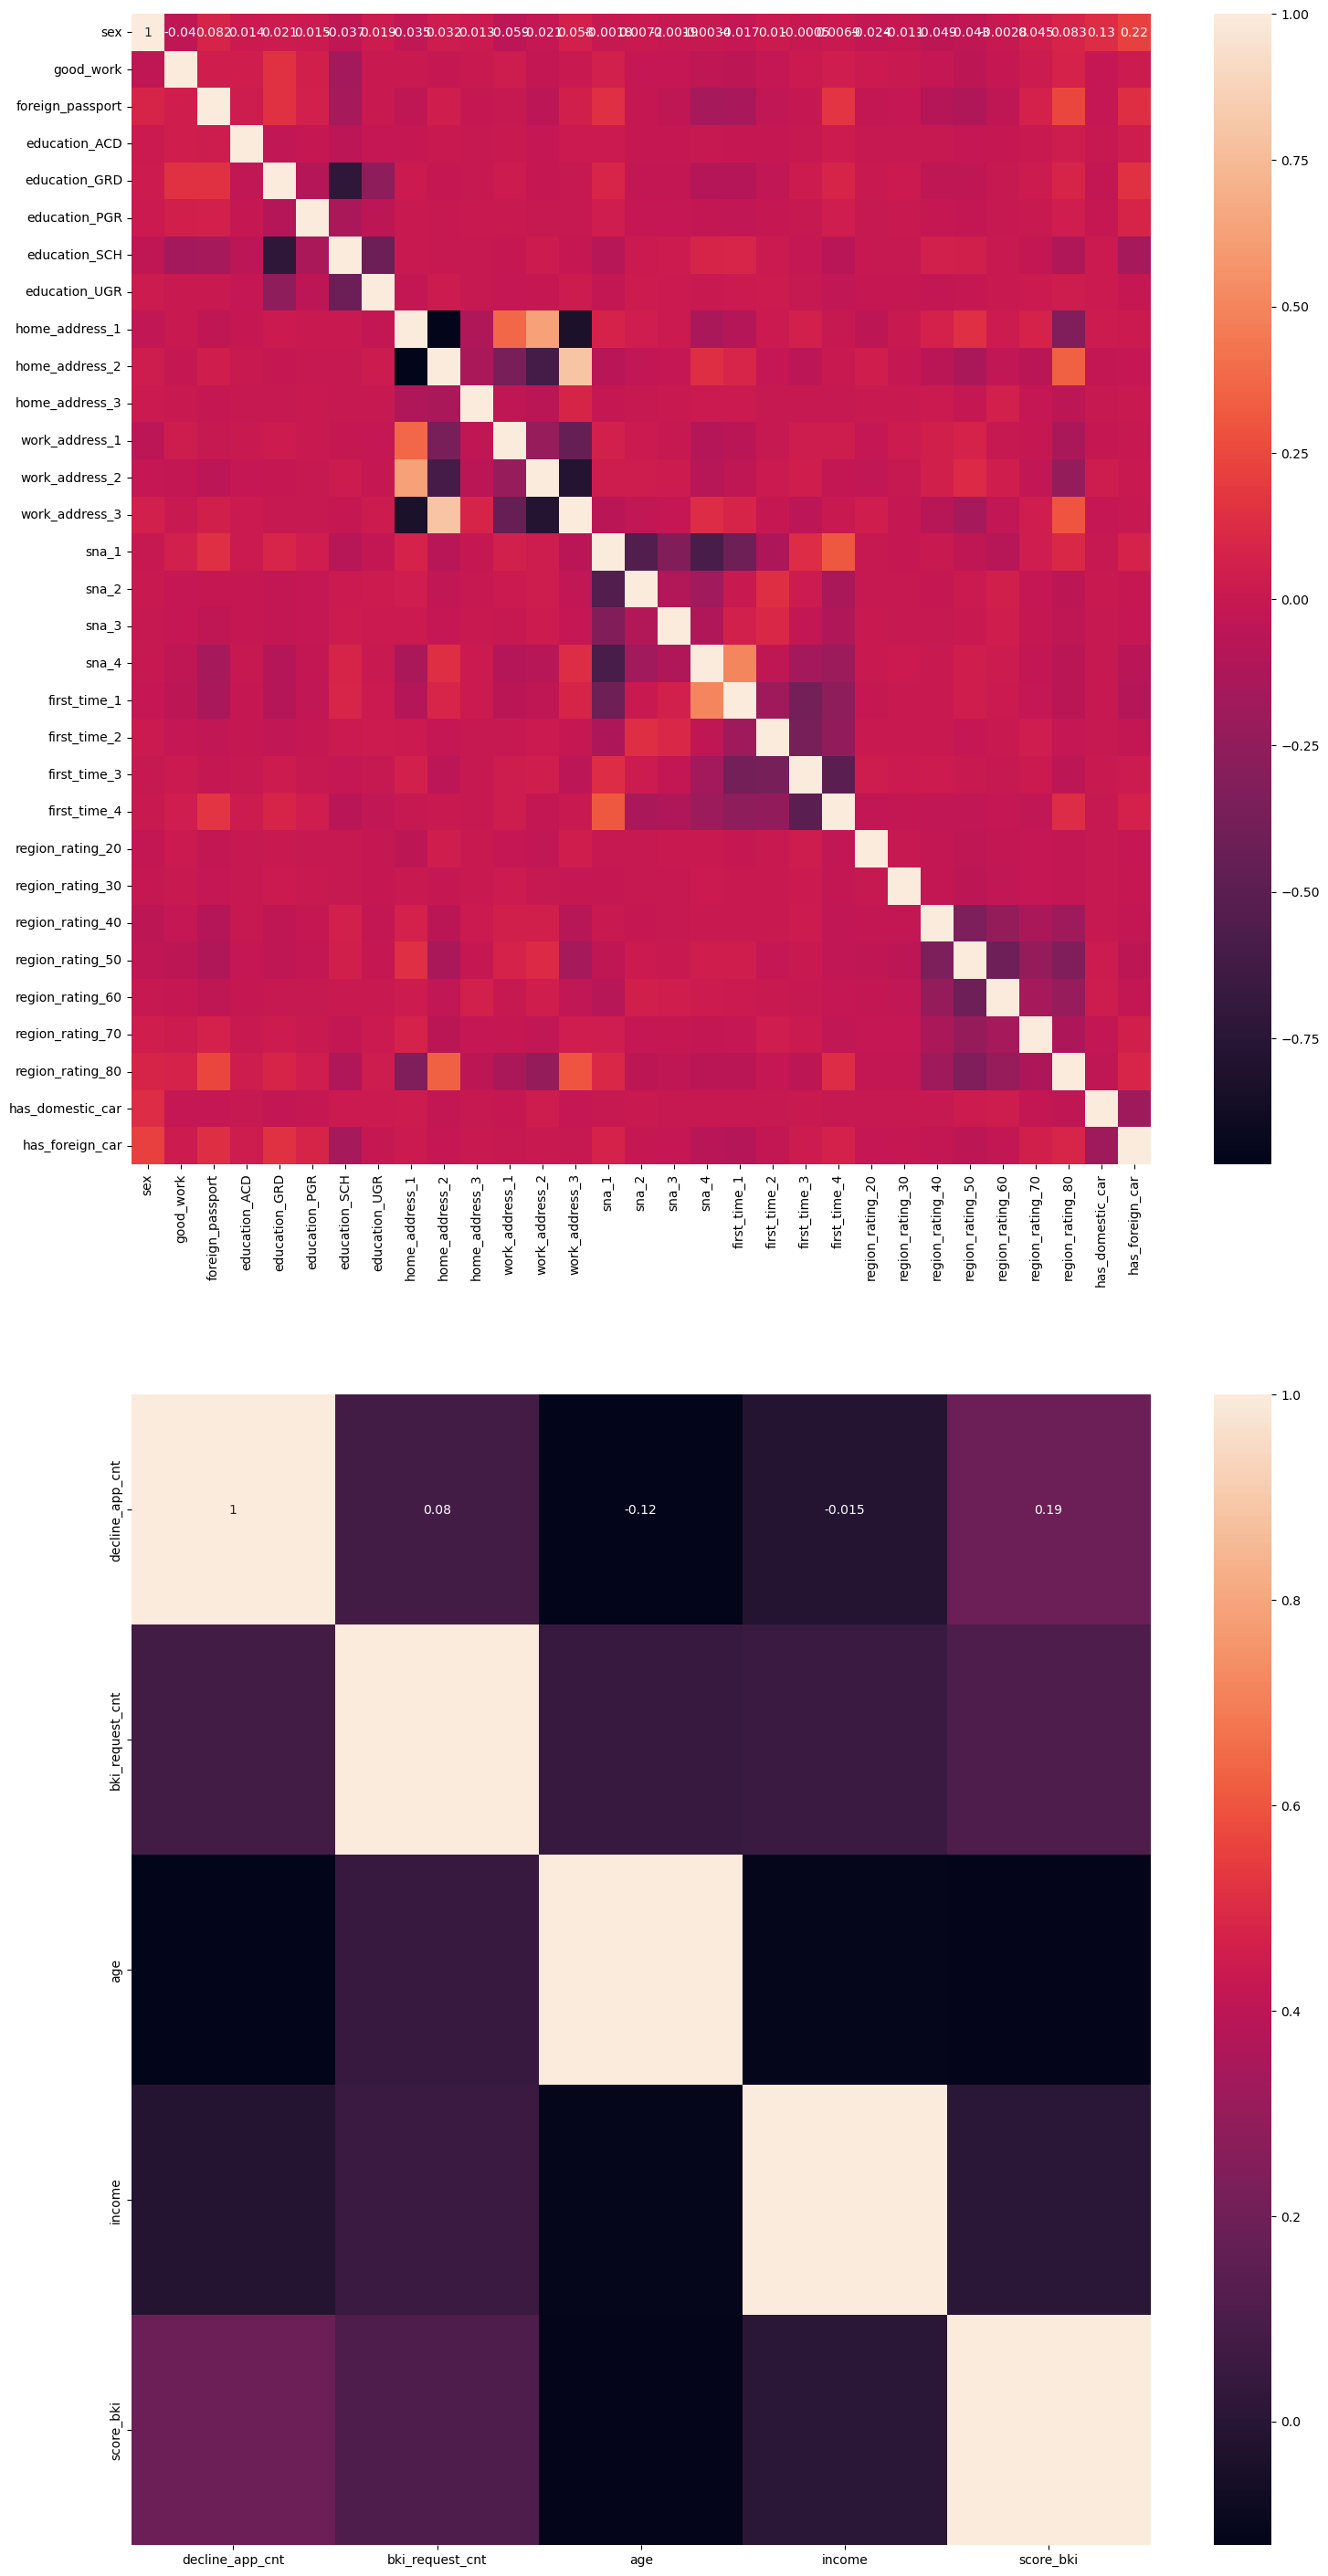

In [92]:
def corr_heatmaps(df_list):
    fig = plt.figure(figsize=(18, 36))
    axes = fig.subplots(2, 1)
    
    for i, (df, method) in enumerate(df_list):
        seaborn.heatmap(df.corr(method=method), annot=True, ax=axes[i])
    
    return axes

cat_cols = ordinal_cols + bin_cols + list(one_hot_encoder.get_feature_names_out(one_hot_cols)) + ['has_domestic_car', 'has_foreign_car']
num_cols = robust_cols + std_cols

corr_heatmaps([(X[cat_cols], 'pearson'), (X[num_cols], 'spearman')]);

Среди числовых признаков мультиколлинеарности нет. Среди категориальных наблюдается высокая корреляция категорий `work_address` и `home_address`. В этом нет ничего удивительного - одному типу рабочего адреса с большей вероятностью вполне может соответствовать какой-то тип домашнего адреса. Оставим это пока как есть.

Проведём статистические тесты на связь данных с целевым признаком. Будем использовать дисперсионный анализ для числовых признаков и хи-квадрат для категориальных.

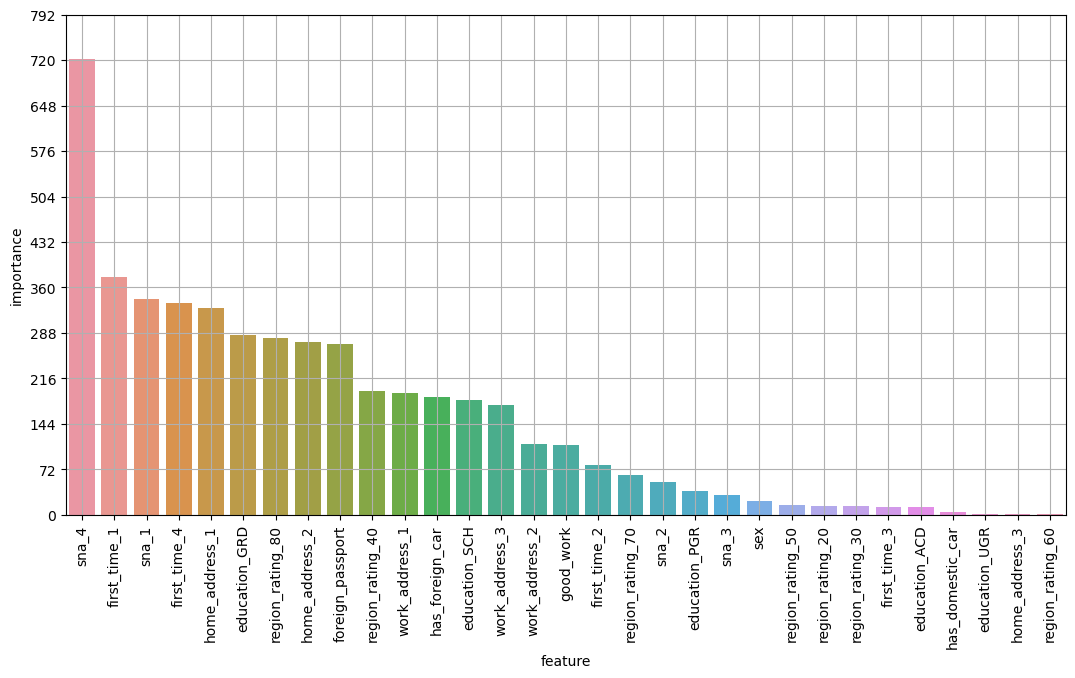

In [93]:
def build_imp_barplot(data, target, test=chi2):
    imp = pd.DataFrame({ 'feature': data.columns, 'importance': test(data, target)[0] }).sort_values('importance', ascending=False)
    imp_max = imp['importance'].max()

    return build_barplot(
        imp['feature'],
        imp['importance'],
        scale=(0, imp_max),
        step=imp_max // 10,
    )

build_imp_barplot(X[cat_cols], y).tick_params('x', labelrotation=90);

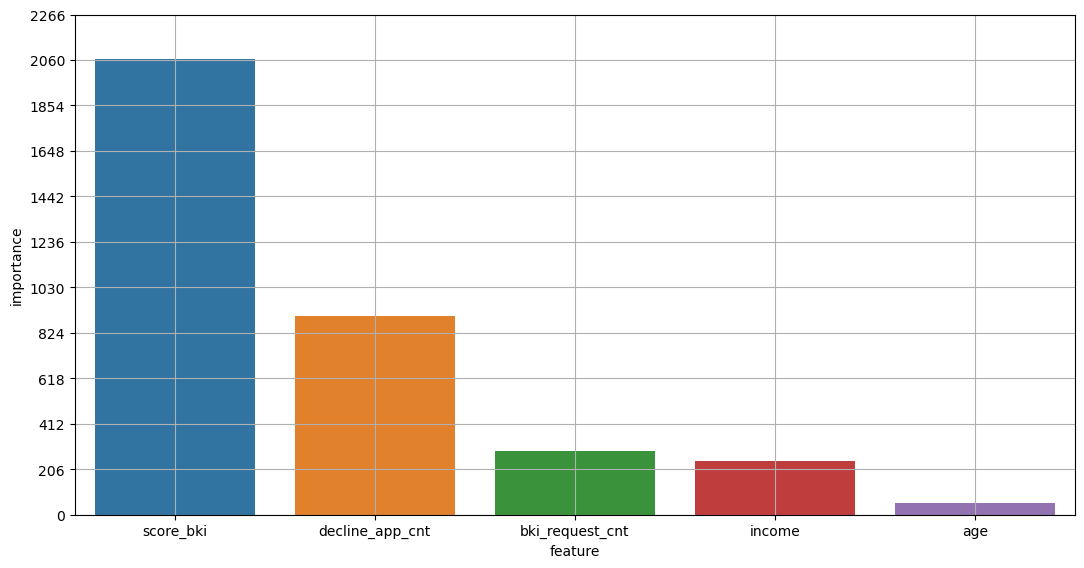

In [94]:
build_imp_barplot(X[num_cols], y, test=f_classif);

По статистическим тестам можем сделать вывод, что в состав наиболее влиятельных категориальных признаков входят `education`, `region_rating`, `foreign_passport`, `has_foreign_car`, `sna_4,1`, `first_time_1,4`, `home_address_1,2`. Признаки `good_work`, `sex`, `has_domestic_car` и др. являются наименее значимыми.

К самым влиятельным числовым признакам относятся `score_bki` и `decline_app_cnt`.

Данные готовы к обучению.

default
0    87.591949
1    12.408051
Name: proportion, dtype: float64

/home/ilya/miniconda3/envs/SOBES/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


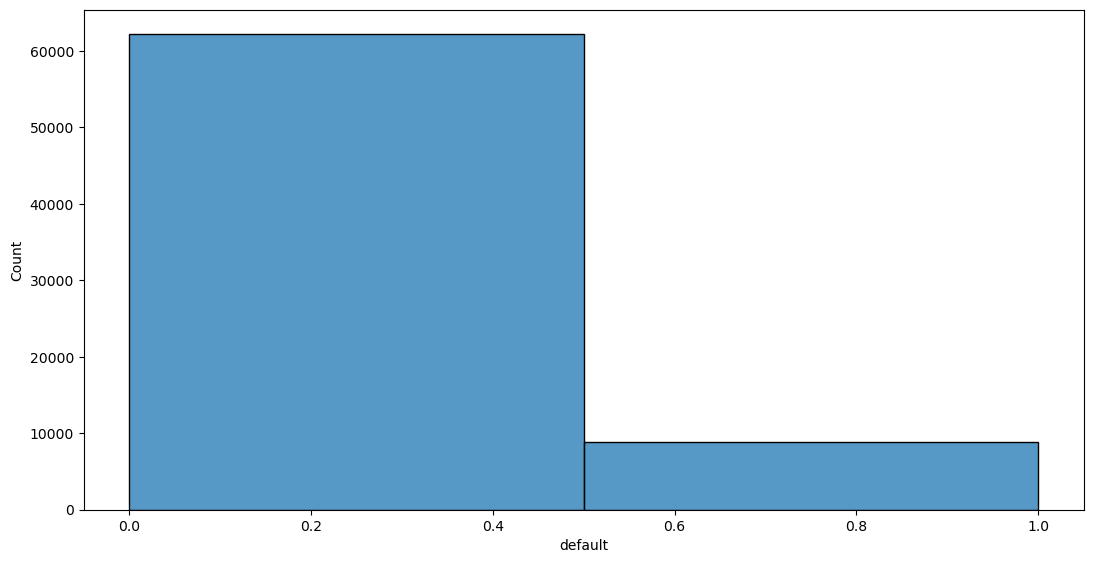

In [95]:
display(y.value_counts(normalize=True) * 100)
build_histplot(y, bins=y.nunique());

Как видим из графика, мы имеем дело с несбалансированной выборкой. Будем делать стратифицированную выборку, обучение произведём с холд-аут выборкой. Модель обучения - логистическая регрессия, в параметрах укажем о необходимости балансировки классов.

In [96]:
log_reg_model = LogisticRegression(max_iter=1000, class_weight='balanced')

In [97]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.2)

log_reg_model.fit(X_train, y_train)
y_train_pred = log_reg_model.predict(X_train)
y_valid_pred = log_reg_model.predict(X_valid)

              precision    recall  f1-score   support

           0       0.94      0.66      0.78     12456
           1       0.22      0.69      0.34      1764

    accuracy                           0.67     14220
   macro avg       0.58      0.68      0.56     14220
weighted avg       0.85      0.67      0.72     14220



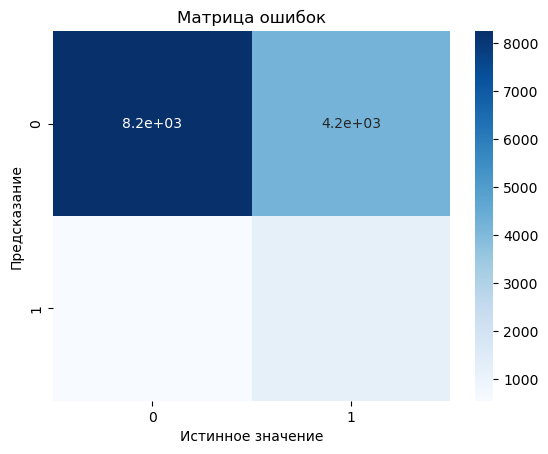

In [98]:
def confusion_matrix_plot(y_true, y_pred, title='Матрица ошибок', ax=None):
    plot = seaborn.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, cmap='Blues', ax=ax)
    plot.set_title(title)
    plot.set_xlabel('Истинное значение')
    plot.set_ylabel('Предсказание')

    return plot

print(classification_report(y_valid, y_valid_pred))
confusion_matrix_plot(y_valid, y_valid_pred);